##  Notebook 01 de 06


(Versão, 14 de Abril de 2025)




# Detecção de Desbalanceamento em Máquinas Rotativas por meio da Análise de Sinais de Vibração utilizando Deep Learning

**Notebook usado como Referência:**

Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt. "Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data". 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020.

## Abordagem 1: Fully-Connected Neural Network

Montando drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Carregando bibliotecas

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import zipfile
from sklearn.preprocessing import RobustScaler

## Carregando base de dados

A base de dados está disponível via Fraunhofer Fortadis data space (https://fordatis.fraunhofer.de/handle/fordatis/151.2). Como o tamanho do dataset completo é de 2.7 GB, este notebook utilizará um subconjunto reduzido do dataset disponível na URL indicada na opção A. No total, são disponibilizados datasets de Treino (D) e Validação (E) para 4 níveis distintos de desbalanceamento (1D/1E ... 4D/4E) e um dataset sem desbalanceamento algum (0D/0E). Cada dataset é estruturado como um arquivo csv com as cinco colunas seguintes:

1. Tensão Aplicada no Motor (V);
2. Velocidade Medida do Motor (RPM);
3. Vibração Sensor 1;
4. Vibração Sensor 2;
5. Vibração Sensor 3.


In [ ]:
# Opção A: Carregamento do dataset via um arquivo local
url = '/content/gdrive/MyDrive/Base de Dados/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option B:  Carregamento do dataset completo via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
use_reference_models = False
model_path = '../models/reference'

# Option d) all models will be trained again
#use_reference_models = False
#model_path = '../models'

In [ ]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

Seleção da configuração de teste

In [ ]:
labels = {'no_unbalance':0, 'unbalance':1}
sensor = 'Vibration_3'
samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

X0,y0 = get_features(data0D[sensor], "no_unbalance")
X1,y1 = get_features(data1D[sensor], "unbalance")
X2,y2 = get_features(data2D[sensor], "unbalance")
X3,y3 = get_features(data3D[sensor], "unbalance")
X4,y4 = get_features(data4D[sensor], "unbalance")
X=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X0_val, y0_val = get_features(data0E[sensor], "no_unbalance")
X1_val, y1_val = get_features(data1E[sensor], "unbalance")
X2_val, y2_val = get_features(data2E[sensor], "unbalance")
X3_val, y3_val = get_features(data3E[sensor], "unbalance")
X4_val, y4_val = get_features(data4E[sensor], "unbalance")
X_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

**Data Augmentation**

In [ ]:
#Data Augmentation
augmentation = False

if(augmentation):
  X0a,y0a = get_features(data0D[sensor].iloc[1024:], "no_unbalance")
  X1a,y1a = get_features(data1D[sensor].iloc[1024:], "unbalance")
  X2a,y2a = get_features(data2D[sensor].iloc[1024:], "unbalance")
  X3a,y3a = get_features(data3D[sensor].iloc[1024:], "unbalance")
  X4a,y4a = get_features(data4D[sensor].iloc[1024:], "unbalance")

  X0b,y0b = get_features(data0D[sensor].iloc[2048:], "no_unbalance")
  X1b,y1b = get_features(data1D[sensor].iloc[2048:], "unbalance")
  X2b,y2b = get_features(data2D[sensor].iloc[2048:], "unbalance")
  X3b,y3b = get_features(data3D[sensor].iloc[2048:], "unbalance")
  X4b,y4b = get_features(data4D[sensor].iloc[2048:], "unbalance")

  X0c,y0c = get_features(data0D[sensor].iloc[3072:], "no_unbalance")
  X1c,y1c = get_features(data1D[sensor].iloc[3072:], "unbalance")
  X2c,y2c = get_features(data2D[sensor].iloc[3072:], "unbalance")
  X3c,y3c = get_features(data3D[sensor].iloc[3072:], "unbalance")
  X4c,y4c = get_features(data4D[sensor].iloc[3072:], "unbalance")

  X=np.concatenate([X, X0a, X1a, X2a, X3a, X4a,
                    X0b, X1b, X2b, X3b, X4b, X0c, X1c, X2c, X3c, X4c])
  y=np.concatenate([y, y0a, y1a, y2a, y3a, y4a,
                    y0b, y1b, y2b, y3b, y4b, y0c, y1c, y2c, y3c, y4c])

O dataset de treinamento X contém 32226 amostras com 4096 (tamanho da janela) valores associados a um vetor y com 32226 rótulos (um rótulo por amostra). O dataset para validação do modelo treinado X_val contém 8420 amostras com 4096 valores associados, respectivamente, aos 8420 rótulos do vetor y_val.

In [ ]:
print(X.shape, y.shape, X_val.shape, y_val.shape)

(32226, 4096) (32226,) (8420, 4096) (8420,)


## Separação Treino e Teste

TO dataset para treinamento (X,y) é dividido em dois subconjuntos (X_train,y_train) e (X_test,y_test).

In [ ]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(29003, 4096) (29003,) (3223, 4096) (3223,)


## Feature Extraction: Preprocessamento dos dados

Podem ser avaliados 03 diferentes tratamentos do sinal de entrada:
1. **TimeDomain**: Sinal de vibração no domínio do tempo (4096 pontos);
2. **FrequencyDomain**: Amplitude da FFT do sinal de vibração (2048 pontos);
3. **EnvelopeSpectrum**: Amplitude do espectro do envelope do sinal de vibração (2048 pontos).

In [ ]:
Sinais_de_Entrada = {'TimeDomain', 'FrequencyDomain', 'EnvelopeSpectrum'}
SinaldeEntrada = 'FrequencyDomain'

**DOMÍNIO DO TEMPO**

In [ ]:
if SinaldeEntrada == 'TimeDomain':
  #Encaixando o domínio do tempo no código
  X_fft = X
  X_train_fft = X_train
  X_test_fft = X_test
  X_val_fft = X_val
  print("Operando com sinal no domínio do tempo")

**DOMÍNIO DA FREQUÊNCIA (FFT)**

In [ ]:
janelamento = False
if SinaldeEntrada == 'FrequencyDomain':

  if(janelamento):
    janela_hanning = np.hanning(window)
    X = X*janela_hanning
    X_train = X_train*janela_hanning
    X_test = X_test*janela_hanning
    X_val = X_val*janela_hanning

  X_fft = np.abs(np.fft.rfft(X, axis=1))[:,:int(window/2)]
  X_train_fft = np.abs(np.fft.rfft(X_train, axis=1))[:,:int(window/2)]
  X_test_fft = np.abs(np.fft.rfft(X_test, axis=1))[:,:int(window/2)]
  X_val_fft = np.abs(np.fft.rfft(X_val, axis=1))[:,:int(window/2)]

  X_fft[:,0]=0
  X_train_fft[:,0]=0
  X_test_fft[:,0]=0
  X_val_fft[:,0]=0

  print("Operando com sinal no domínio da frequência")

Operando com sinal no domínio da frequência


**ENVELOPE SPECTRUM:** Espectro de Fourier da envoltória do sinal de vibração

In [ ]:
filtrar_sinal = False

if SinaldeEntrada == 'EnvelopeSpectrum':

  #Importando bibliotecas
  import scipy.signal as signal

  if(filtrar_sinal):
    #Filtrando o sinal (Opcional)
    fs = 4096  # Exemplo: taxa de amostragem em Hz
    lowcut = 1000
    highcut = 10000
    b, a = signal.butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    x_filtered = signal.filtfilt(b, a, x)  # x é o sinal original

  #Extraindo o envelope do sinal com a Transformada de Hilbert

  analytic_signal_X  = signal.hilbert(X)
  envelope_X = np.abs(analytic_signal_X)

  analytic_signal_X_train = signal.hilbert(X_train)
  envelope_X_train = np.abs(analytic_signal_X_train)

  analytic_signal_X_test = signal.hilbert(X_test)
  envelope_X_test = np.abs(analytic_signal_X_test)

  analytic_signal_X_val = signal.hilbert(X_val)
  envelope_X_val = np.abs(analytic_signal_X_val)

  #Calcular o espectro do envelope por meio da Transformada De Fourier
  envelope_spectrum_X = np.abs(np.fft.rfft(envelope_X, axis=1))[:,:int(window/2)]

  envelope_spectrum_X_train = np.abs(np.fft.rfft(envelope_X_train, axis=1))[:,:int(window/2)]

  envelope_spectrum_X_test = np.abs(np.fft.rfft(envelope_X_test, axis=1))[:,:int(window/2)]

  envelope_spectrum_X_val = np.abs(np.fft.rfft(envelope_X_val, axis=1))[:,:int(window/2)]

  #"Encaixando" o sinal do envelope spectrum no código
  X_fft = envelope_spectrum_X
  X_train_fft = envelope_spectrum_X_train
  X_test_fft = envelope_spectrum_X_test
  X_val_fft = envelope_spectrum_X_val

  #Garbage collection
  del analytic_signal_X, analytic_signal_X_train, analytic_signal_X_test, analytic_signal_X_val
  del envelope_X, envelope_X_train, envelope_X_test, envelope_X_val
  del envelope_spectrum_X, envelope_spectrum_X_train, envelope_spectrum_X_test, envelope_spectrum_X_val
  print("Operando com Envelope Spectrum")


O shape com a FFT ou o Envelope Spectrum deve ser: (29003, 2048) (3223, 2048) (8420, 2048)

O shape no Dominio do Tempo deve ser: (29003, 4096) (3223, 4096) (8420, 4096)

In [ ]:
print(X_train_fft.shape, X_test_fft.shape, X_val_fft.shape)

(29003, 2048) (3223, 2048) (8420, 2048)


## Scaling

In [ ]:
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train_fft)

X_fft_sc = scaler.transform(X_fft)
X_train_fft_sc = scaler.transform(X_train_fft)
X_test_fft_sc = scaler.transform(X_test_fft)
X_val_fft_sc = scaler.transform(X_val_fft)

NameError: name 'RobustScaler' is not defined

## Fully-Connected Neural Network (FCN)

## Passo 1: Avaliação do desempenho do modelo em função do número de camadas

Cinco Fully Connected Neural Networks (FCN) de zero (equivalente a Logistic Regression) a
quatro hidden layers são treinadas utilizando os dados de treinamento.

In [ ]:
X_val_fft_1 = X_val_fft_sc[:len(y0_val),:]
y_val_1 = y_val[:len(y0_val)]
X_val_fft_2 = X_val_fft_sc[len(y0_val):len(y0_val)+len(y1_val),:]
y_val_2 = y_val[len(y0_val):len(y0_val)+len(y1_val)]
X_val_fft_3 = X_val_fft_sc[len(y0_val)+len(y1_val):len(y0_val)+
                           len(y1_val)+len(y2_val),:]
y_val_3 = y_val[len(y0_val)+len(y1_val):len(y0_val)+len(y1_val)+
                len(y2_val)]
X_val_fft_4 = X_val_fft_sc[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+
                           len(y1_val)+len(y2_val)+len(y3_val),:]
y_val_4 = y_val[len(y0_val)+len(y1_val)+len(y2_val):len(y0_val)+len(y1_val)+
                len(y2_val)+len(y3_val)]
X_val_fft_5 = X_val_fft_sc[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+
                           len(y1_val)+len(y2_val)+len(y3_val)+len(y4_val),:]
y_val_5 = y_val[len(y0_val)+len(y1_val)+len(y2_val)+len(y3_val):len(y0_val)+len(y1_val)+
                len(y2_val)+len(y3_val)+len(y4_val)]

In [ ]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

In [ ]:
if not use_reference_models:

    weight_for_0 = len(y)/(2*len(y[y==0]))
    weight_for_1 = len(y)/(2*len(y[y==1]))
    class_weight = {0: weight_for_0, 1: weight_for_1}

    epochs = 100

    for i in range(5):
        X_in = Input(shape=(X_train_fft.shape[1],), name="cam_layer")
        x = X_in
        for j in range(i):
            x = Dense(units = 1024, activation="linear")(x)
            x = LeakyReLU(alpha=0.05)(x)
        X_out = Dense(units = 1, activation = 'sigmoid')(x)
        model_i = Model(X_in, X_out)


        best_model_filepath = f"{model_path}/fft_fcn_{i}_layers.h5"
        checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                     verbose=1, save_best_only=True, mode='min')

        model_i.compile(optimizer = Adam(learning_rate=0.0005), loss = 'binary_crossentropy',
                        metrics = ['accuracy'])
        model_i.summary()

        model_i.fit(X_train_fft_sc, y_train, epochs = 100, batch_size = 128,
                       validation_data=(X_test_fft_sc, y_test), callbacks=[checkpoint],
                    class_weight=class_weight)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6696 - loss: 0.5931
Epoch 1: val_loss improved from inf to 0.47470, saving model to ../models/reference/fft_fcn_0_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6698 - loss: 0.5931 - val_accuracy: 0.7927 - val_loss: 0.4747
Epoch 2/100
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7816 - loss: 0.3359
Epoch 2: val_loss did not improve from 0.47470
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7817 - loss: 0.3360 - val_accuracy: 0.7794 - val_loss: 0.6170
Epoch 3/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.3322
Epoch 3: val_loss did not improve from 0.47470
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8060 - loss: 0.3325 - val_accuracy: 0.8107 - val_loss: 0.4798
Epoch 4/100
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8335 - loss: 0.2816
Epoch 4: val_loss improved from 0.47470 to 0.38685, saving model to ../models/reference/fft_fcn_0_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8340 - loss: 0.2816 - val_accuracy: 0.8917 - val_loss: 0.3869
Epoch 5/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8534 - loss: 0.3109
Epoch 5: val_loss improved from 0.38685 to 0.29859, saving model to ../models/reference/fft_fcn_0_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8529 - loss: 0.3111 - val_accuracy: 0.8604 - val_loss: 0.2986
Epoch 6/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8637 - loss: 0.2626
Epoch 6: val_loss did not improve from 0.29859
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8639 - loss: 0.2635 - val_accuracy: 0.8998 - val_loss: 0.5993
Epoch 7/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8633 - loss: 0.3159
Epoch 7: val_loss improved from 0.29859 to 0.26559, saving model to ../models/reference/fft_fcn_0_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8635 - loss: 0.3142 - val_accuracy: 0.8765 - val_loss: 0.2656
Epoch 8/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.2687
Epoch 8: val_loss did not improve from 0.26559
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8791 - loss: 0.2688 - val_accuracy: 0.8657 - val_loss: 0.2928
Epoch 9/100
223/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8780 - loss: 0.2162
Epoch 9: val_loss did not improve from 0.26559
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8781 - loss: 0.2164 - val_accuracy: 0.8774 - val_loss: 0.6082
Epoch 10/100
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8749 - loss: 0.2527
Epoch 10: val_loss improved from 0.26559 to 0.22609, saving model to ../models/reference/fft_fcn_0_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.2524 - val_accuracy: 0.8945 - val_loss: 0.2261
Epoch 11/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8965 - loss: 0.2137
Epoch 11: val_loss did not improve from 0.22609
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8964 - loss: 0.2139 - val_accuracy: 0.8734 - val_loss: 0.6327
Epoch 12/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8789 - loss: 0.2817
Epoch 12: val_loss did not improve from 0.22609
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8794 - loss: 0.2802 - val_accuracy: 0.9184 - val_loss: 0.6167
Epoch 13/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8879 - loss: 0.2725
Epoch 13: val_loss did not improve from 0.22609
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8881 - loss: 0.2719 - val_accuracy: 0.8852 - val_loss: 0.2644
Epoch 14/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8977 - loss: 0.1994
Epoch 14: val_loss improved from 0.2

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8977 - loss: 0.1997 - val_accuracy: 0.8967 - val_loss: 0.2134
Epoch 15/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9014 - loss: 0.2100
Epoch 15: val_loss did not improve from 0.21336
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9014 - loss: 0.2110 - val_accuracy: 0.9231 - val_loss: 0.3372
Epoch 16/100
223/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8986 - loss: 0.1925
Epoch 16: val_loss did not improve from 0.21336
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8987 - loss: 0.1931 - val_accuracy: 0.8889 - val_loss: 0.5007
Epoch 17/100
218/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8958 - loss: 0.2088
Epoch 17: val_loss did not improve from 0.21336
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8962 - loss: 0.2086 - val_accuracy: 0.9069 - val_loss: 0.2567
Epoch 18/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9047 - loss: 0.1961
Epoch 18: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9070 - loss: 0.2062 - val_accuracy: 0.9187 - val_loss: 0.1774
Epoch 20/100
223/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9164 - loss: 0.1839
Epoch 20: val_loss did not improve from 0.17736
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9163 - loss: 0.1839 - val_accuracy: 0.9038 - val_loss: 0.1930
Epoch 21/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9159 - loss: 0.1839
Epoch 21: val_loss did not improve from 0.17736
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9159 - loss: 0.1845 - val_accuracy: 0.9125 - val_loss: 0.5945
Epoch 22/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9028 - loss: 0.2119
Epoch 22: val_loss did not improve from 0.17736
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9029 - loss: 0.2119 - val_accuracy: 0.9504 - val_loss: 0.3699
Epoch 23/100
213/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9198 - loss: 0.1940
Epoch 23: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9141 - loss: 0.1952 - val_accuracy: 0.9277 - val_loss: 0.1745
Epoch 25/100
218/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9165 - loss: 0.1602
Epoch 25: val_loss did not improve from 0.17453
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9167 - loss: 0.1607 - val_accuracy: 0.9110 - val_loss: 0.4845
Epoch 26/100
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9122 - loss: 0.2495
Epoch 26: val_loss did not improve from 0.17453
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9125 - loss: 0.2455 - val_accuracy: 0.9013 - val_loss: 0.4568
Epoch 27/100
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9114 - loss: 0.2048
Epoch 27: val_loss did not improve from 0.17453
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9116 - loss: 0.2043 - val_accuracy: 0.9274 - val_loss: 0.1990
Epoch 28/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9246 - loss: 0.1686
Epoch 28: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9158 - loss: 0.2021 - val_accuracy: 0.9122 - val_loss: 0.1674
Epoch 32/100
224/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9229 - loss: 0.1597
Epoch 32: val_loss did not improve from 0.16740
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9229 - loss: 0.1597 - val_accuracy: 0.9091 - val_loss: 0.1731
Epoch 33/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9336 - loss: 0.2211
Epoch 33: val_loss improved from 0.16740 to 0.16379, saving model to ../models/reference/fft_fcn_0_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9334 - loss: 0.2208 - val_accuracy: 0.9196 - val_loss: 0.1638
Epoch 34/100
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9218 - loss: 0.1488
Epoch 34: val_loss did not improve from 0.16379
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9220 - loss: 0.1490 - val_accuracy: 0.9029 - val_loss: 0.1871
Epoch 35/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9211 - loss: 0.1827
Epoch 35: val_loss did not improve from 0.16379
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9211 - loss: 0.1833 - val_accuracy: 0.9001 - val_loss: 0.1892
Epoch 36/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9222 - loss: 0.1456
Epoch 36: val_loss did not improve from 0.16379
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9223 - loss: 0.1459 - val_accuracy: 0.9088 - val_loss: 0.1752
Epoch 37/100
215/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9208 - loss: 0.1497
Epoch 37: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9273 - loss: 0.1339 - val_accuracy: 0.9274 - val_loss: 0.1473
Epoch 56/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9317 - loss: 0.1295
Epoch 56: val_loss improved from 0.14725 to 0.13165, saving model to ../models/reference/fft_fcn_0_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9317 - loss: 0.1294 - val_accuracy: 0.9336 - val_loss: 0.1316
Epoch 57/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9386 - loss: 0.1321
Epoch 57: val_loss did not improve from 0.13165
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9387 - loss: 0.1325 - val_accuracy: 0.9162 - val_loss: 0.5356
Epoch 58/100
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.1414
Epoch 58: val_loss did not improve from 0.13165
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9283 - loss: 0.1422 - val_accuracy: 0.9283 - val_loss: 0.4905
Epoch 59/100
220/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9314 - loss: 0.1411
Epoch 59: val_loss did not improve from 0.13165
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9316 - loss: 0.1419 - val_accuracy: 0.9187 - val_loss: 0.2346
Epoch 60/100
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9355 - loss: 0.1505
Epoch 60: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9334 - loss: 0.1258 - val_accuracy: 0.9640 - val_loss: 0.1062
Epoch 68/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9582 - loss: 0.1386
Epoch 68: val_loss did not improve from 0.10618
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9577 - loss: 0.1392 - val_accuracy: 0.9342 - val_loss: 0.3963
Epoch 69/100
208/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9330 - loss: 0.1233
Epoch 69: val_loss did not improve from 0.10618
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9333 - loss: 0.1230 - val_accuracy: 0.9271 - val_loss: 0.1354
Epoch 70/100
223/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9441 - loss: 0.1524
Epoch 70: val_loss did not improve from 0.10618
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9440 - loss: 0.1528 - val_accuracy: 0.9364 - val_loss: 0.2575
Epoch 71/100
212/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9400 - loss: 0.1321
Epoch 71: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9507 - loss: 0.1498 - val_accuracy: 0.9513 - val_loss: 0.1046
Epoch 96/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9604 - loss: 0.1314
Epoch 96: val_loss did not improve from 0.10457
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9602 - loss: 0.1306 - val_accuracy: 0.9445 - val_loss: 0.1105
Epoch 97/100
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9551 - loss: 0.1135
Epoch 97: val_loss did not improve from 0.10457
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9551 - loss: 0.1132 - val_accuracy: 0.9420 - val_loss: 0.1117
Epoch 98/100
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9547 - loss: 0.1324
Epoch 98: val_loss did not improve from 0.10457
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9547 - loss: 0.1325 - val_accuracy: 0.9283 - val_loss: 0.1272
Epoch 99/100
215/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9496 - loss: 0.1304
Epoch 99: val_loss did not improve f

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,201 (8.01 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8344 - loss: 0.8986
Epoch 1: val_loss improved from inf to 0.09076, saving model to ../models/reference/fft_fcn_1_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8346 - loss: 0.8984 - val_accuracy: 0.9814 - val_loss: 0.0908
Epoch 2/100
209/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9404 - loss: 0.6919
Epoch 2: val_loss did not improve from 0.09076
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9410 - loss: 0.6846 - val_accuracy: 0.9016 - val_loss: 0.2893
Epoch 3/100
208/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8682 - loss: 0.7766
Epoch 3: val_loss did not improve from 0.09076
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8739 - loss: 0.7506 - val_accuracy: 0.9404 - val_loss: 0.8694
Epoch 4/100
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9605 - loss: 0.4890
Epoch 4: val_loss did not improve from 0.09076
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9603 - loss: 0.4986 - val_accuracy: 0.9463 - val_loss: 2.9114
Epoch 5/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9757 - loss: 0.5181
Epoch 5: val_loss did not improve from 0.09

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9890 - loss: 0.1028 - val_accuracy: 0.9857 - val_loss: 0.0463
Epoch 11/100
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9560 - loss: 0.5833
Epoch 11: val_loss did not improve from 0.04629
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9562 - loss: 0.5939 - val_accuracy: 0.9904 - val_loss: 1.3229
Epoch 12/100
206/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9673 - loss: 0.7822
Epoch 12: val_loss did not improve from 0.04629
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9670 - loss: 0.7889 - val_accuracy: 0.9749 - val_loss: 2.0594
Epoch 13/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.7742
Epoch 13: val_loss did not improve from 0.04629
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 0.7727 - val_accuracy: 0.9801 - val_loss: 0.8179
Epoch 14/100
207/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.3355
Epoch 14: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9827 - loss: 0.6684 - val_accuracy: 0.9929 - val_loss: 0.0398
Epoch 19/100
211/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.3399
Epoch 19: val_loss did not improve from 0.03981
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9915 - loss: 0.3540 - val_accuracy: 0.9839 - val_loss: 1.1934
Epoch 20/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.3118
Epoch 20: val_loss did not improve from 0.03981
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.3148 - val_accuracy: 0.9786 - val_loss: 1.1488
Epoch 21/100
209/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0582
Epoch 21: val_loss did not improve from 0.03981
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9922 - loss: 0.0634 - val_accuracy: 0.9957 - val_loss: 0.2460
Epoch 22/100
218/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.2917
Epoch 22: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9938 - loss: 0.4705 - val_accuracy: 0.9913 - val_loss: 0.0284
Epoch 24/100
211/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0802
Epoch 24: val_loss did not improve from 0.02837
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9941 - loss: 0.0886 - val_accuracy: 0.9845 - val_loss: 2.1039
Epoch 25/100
215/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.3831
Epoch 25: val_loss improved from 0.02837 to 0.01933, saving model to ../models/reference/fft_fcn_1_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9916 - loss: 0.3731 - val_accuracy: 0.9966 - val_loss: 0.0193
Epoch 26/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0393
Epoch 26: val_loss did not improve from 0.01933
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9956 - loss: 0.0431 - val_accuracy: 0.9777 - val_loss: 0.3807
Epoch 27/100
215/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0973
Epoch 27: val_loss did not improve from 0.01933
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9948 - loss: 0.1098 - val_accuracy: 0.9975 - val_loss: 0.6032
Epoch 28/100
215/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0850
Epoch 28: val_loss did not improve from 0.01933
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9959 - loss: 0.0841 - val_accuracy: 0.9305 - val_loss: 1.6800
Epoch 29/100
209/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.1410
Epoch 29: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9943 - loss: 0.2441 - val_accuracy: 0.9984 - val_loss: 0.0095
Epoch 42/100
209/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.1583
Epoch 42: val_loss did not improve from 0.00946
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9950 - loss: 0.1599 - val_accuracy: 0.9975 - val_loss: 0.0112
Epoch 43/100
204/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.1102
Epoch 43: val_loss did not improve from 0.00946
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9952 - loss: 0.1114 - val_accuracy: 0.9969 - val_loss: 0.0144
Epoch 44/100
207/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0103
Epoch 44: val_loss did not improve from 0.00946
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9983 - loss: 0.0109 - val_accuracy: 0.9724 - val_loss: 0.7044
Epoch 45/100
208/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.2079
Epoch 45: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0645 - val_accuracy: 0.9994 - val_loss: 0.0077
Epoch 47/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.2083
Epoch 47: val_loss did not improve from 0.00769
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9946 - loss: 0.2084 - val_accuracy: 0.9786 - val_loss: 0.1068
Epoch 48/100
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.1055
Epoch 48: val_loss did not improve from 0.00769
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9926 - loss: 0.1064 - val_accuracy: 0.9466 - val_loss: 0.8111
Epoch 49/100
207/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.1060
Epoch 49: val_loss did not improve from 0.00769
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9934 - loss: 0.1155 - val_accuracy: 0.9991 - val_loss: 0.0117
Epoch 50/100
204/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0266
Epoch 50: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.2877 - val_accuracy: 0.9988 - val_loss: 0.0069
Epoch 62/100
212/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0748
Epoch 62: val_loss did not improve from 0.00689
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9974 - loss: 0.0830 - val_accuracy: 0.9963 - val_loss: 1.2695
Epoch 63/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.1238
Epoch 63: val_loss did not improve from 0.00689
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9972 - loss: 0.1272 - val_accuracy: 0.9969 - val_loss: 0.1141
Epoch 64/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.1734
Epoch 64: val_loss did not improve from 0.00689
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9954 - loss: 0.1741 - val_accuracy: 0.9984 - val_loss: 0.0091
Epoch 65/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.1456
Epoch 65: val_loss did not improve f

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,801 (12.01 MB)

 Trainable params: 3,148,801 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8278 - loss: 1.2063
Epoch 1: val_loss improved from inf to 0.06574, saving model to ../models/reference/fft_fcn_2_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8281 - loss: 1.2044 - val_accuracy: 0.9870 - val_loss: 0.0657
Epoch 2/100
206/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.1431
Epoch 2: val_loss improved from 0.06574 to 0.04733, saving model to ../models/reference/fft_fcn_2_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9740 - loss: 0.1544 - val_accuracy: 0.9907 - val_loss: 0.0473
Epoch 3/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0778
Epoch 3: val_loss did not improve from 0.04733
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9834 - loss: 0.0793 - val_accuracy: 0.9857 - val_loss: 0.0665
Epoch 4/100
206/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.2691
Epoch 4: val_loss did not improve from 0.04733
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9848 - loss: 0.2674 - val_accuracy: 0.9848 - val_loss: 0.9513
Epoch 5/100
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.2191
Epoch 5: val_loss improved from 0.04733 to 0.01367, saving model to ../models/reference/fft_fcn_2_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9815 - loss: 0.2184 - val_accuracy: 0.9978 - val_loss: 0.0137
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9905 - loss: 0.0643
Epoch 6: val_loss did not improve from 0.01367
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9905 - loss: 0.0643 - val_accuracy: 0.9960 - val_loss: 0.0142
Epoch 7/100
213/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9367 - loss: 0.9671
Epoch 7: val_loss improved from 0.01367 to 0.01247, saving model to ../models/reference/fft_fcn_2_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9388 - loss: 0.9374 - val_accuracy: 0.9988 - val_loss: 0.0125
Epoch 8/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.1293
Epoch 8: val_loss did not improve from 0.01247
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9886 - loss: 0.1329 - val_accuracy: 0.9873 - val_loss: 0.0481
Epoch 9/100
209/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.1511
Epoch 9: val_loss did not improve from 0.01247
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9957 - loss: 0.1498 - val_accuracy: 0.9994 - val_loss: 0.0206
Epoch 10/100
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.1226
Epoch 10: val_loss improved from 0.01247 to 0.00937, saving model to ../models/reference/fft_fcn_2_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.1183 - val_accuracy: 0.9994 - val_loss: 0.0094
Epoch 11/100
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.4152
Epoch 11: val_loss did not improve from 0.00937
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9973 - loss: 0.4082 - val_accuracy: 0.9969 - val_loss: 0.1945
Epoch 12/100
212/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0785
Epoch 12: val_loss improved from 0.00937 to 0.00697, saving model to ../models/reference/fft_fcn_2_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0787 - val_accuracy: 0.9978 - val_loss: 0.0070
Epoch 13/100
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0279
Epoch 13: val_loss did not improve from 0.00697
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0283 - val_accuracy: 0.9981 - val_loss: 0.1644
Epoch 14/100
211/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0438
Epoch 14: val_loss did not improve from 0.00697
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9989 - loss: 0.0433 - val_accuracy: 0.9957 - val_loss: 0.3109
Epoch 15/100
208/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0369
Epoch 15: val_loss did not improve from 0.00697
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0374 - val_accuracy: 0.9975 - val_loss: 0.0801
Epoch 16/100
221/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0132
Epoch 16: val_loss improved from 0.0

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9979 - loss: 0.0132 - val_accuracy: 0.9988 - val_loss: 0.0059
Epoch 17/100
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9974 - loss: 0.0342
Epoch 17: val_loss did not improve from 0.00594
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9974 - loss: 0.0342 - val_accuracy: 0.9978 - val_loss: 0.0452
Epoch 18/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0222
Epoch 18: val_loss did not improve from 0.00594
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9969 - loss: 0.0223 - val_accuracy: 0.9988 - val_loss: 0.0060
Epoch 19/100
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0515
Epoch 19: val_loss improved from 0.00594 to 0.00208, saving model to ../models/reference/fft_fcn_2_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0513 - val_accuracy: 0.9994 - val_loss: 0.0021
Epoch 20/100
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0045
Epoch 20: val_loss did not improve from 0.00208
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9994 - loss: 0.0046 - val_accuracy: 0.9981 - val_loss: 0.0650
Epoch 21/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0744
Epoch 21: val_loss did not improve from 0.00208
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9939 - loss: 0.0728 - val_accuracy: 0.9991 - val_loss: 0.0038
Epoch 22/100
215/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0320
Epoch 22: val_loss did not improve from 0.00208
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9983 - loss: 0.0328 - val_accuracy: 0.9984 - val_loss: 0.0074
Epoch 23/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0461
Epoch 23: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9955 - loss: 0.0298 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 36/100
206/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0103
Epoch 36: val_loss did not improve from 0.00192
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9991 - loss: 0.0105 - val_accuracy: 0.9944 - val_loss: 0.1476
Epoch 37/100
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0311
Epoch 37: val_loss did not improve from 0.00192
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9955 - loss: 0.0314 - val_accuracy: 0.9972 - val_loss: 0.1790
Epoch 38/100
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.4971
Epoch 38: val_loss did not improve from 0.00192
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9961 - loss: 0.4882 - val_accuracy: 0.9969 - val_loss: 0.0472
Epoch 39/100
222/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.1191
Epoch 39: val_loss did not improve f

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,198,401 (16.02 MB)

 Trainable params: 4,198,401 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8282 - loss: 1.1701
Epoch 1: val_loss improved from inf to 0.05933, saving model to ../models/reference/fft_fcn_3_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8284 - loss: 1.1681 - val_accuracy: 0.9876 - val_loss: 0.0593
Epoch 2/100
211/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9577 - loss: 0.2087
Epoch 2: val_loss did not improve from 0.05933
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9574 - loss: 0.2247 - val_accuracy: 0.9038 - val_loss: 1.2402
Epoch 3/100
213/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9728 - loss: 0.1569
Epoch 3: val_loss improved from 0.05933 to 0.00986, saving model to ../models/reference/fft_fcn_3_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9734 - loss: 0.1524 - val_accuracy: 0.9988 - val_loss: 0.0099
Epoch 4/100
208/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0572
Epoch 4: val_loss did not improve from 0.00986
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9790 - loss: 0.0602 - val_accuracy: 0.9826 - val_loss: 0.2718
Epoch 5/100
209/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0708
Epoch 5: val_loss did not improve from 0.00986
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9880 - loss: 0.0715 - val_accuracy: 0.9919 - val_loss: 0.0281
Epoch 6/100
207/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0676
Epoch 6: val_loss did not improve from 0.00986
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9870 - loss: 0.0672 - val_accuracy: 0.9978 - val_loss: 0.0104
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0370
Epoch 7: val_loss improved from 0.00986 to 

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9979 - loss: 0.0370 - val_accuracy: 0.9988 - val_loss: 0.0023
Epoch 8/100
223/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0065
Epoch 8: val_loss did not improve from 0.00227
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9975 - loss: 0.0066 - val_accuracy: 0.9895 - val_loss: 0.2344
Epoch 9/100
211/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8926 - loss: 0.3026
Epoch 9: val_loss did not improve from 0.00227
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8964 - loss: 0.2925 - val_accuracy: 0.9870 - val_loss: 0.2546
Epoch 10/100
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0496
Epoch 10: val_loss did not improve from 0.00227
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9931 - loss: 0.0500 - val_accuracy: 0.9922 - val_loss: 0.0218
Epoch 11/100
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.1233
Epoch 11: val_loss did not improve from 

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0112 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 40/100
210/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0038
Epoch 40: val_loss did not improve from 0.00150
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 0.9997 - val_loss: 0.0038
Epoch 41/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0055
Epoch 41: val_loss did not improve from 0.00150
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0055 - val_accuracy: 0.9981 - val_loss: 0.0415
Epoch 42/100
208/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0212
Epoch 42: val_loss did not improve from 0.00150
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.0219 - val_accuracy: 0.9541 - val_loss: 0.2027
Epoch 43/100
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0300
Epoch 43: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9986 - loss: 0.0334 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 48/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0025
Epoch 48: val_loss did not improve from 0.00140
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0025 - val_accuracy: 0.9991 - val_loss: 0.0627
Epoch 49/100
209/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9715 - loss: 1.4336
Epoch 49: val_loss did not improve from 0.00140
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9716 - loss: 1.3970 - val_accuracy: 0.9742 - val_loss: 0.1297
Epoch 50/100
209/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.3469
Epoch 50: val_loss did not improve from 0.00140
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9887 - loss: 0.3692 - val_accuracy: 0.9988 - val_loss: 0.0082
Epoch 51/100
208/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.1500
Epoch 51: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9989 - loss: 0.1314 - val_accuracy: 0.9997 - val_loss: 9.9541e-04
Epoch 59/100
226/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0532
Epoch 59: val_loss did not improve from 0.00100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0541 - val_accuracy: 0.9978 - val_loss: 0.0336
Epoch 60/100
225/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0991
Epoch 60: val_loss did not improve from 0.00100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0990 - val_accuracy: 0.9981 - val_loss: 0.6556
Epoch 61/100
211/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.1057
Epoch 61: val_loss did not improve from 0.00100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9981 - loss: 0.1103 - val_accuracy: 0.9885 - val_loss: 0.0330
Epoch 62/100
211/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0477
Epoch 62: val_loss did not impro

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248,001 (20.02 MB)

 Trainable params: 5,248,001 (20.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8364 - loss: 3.6462
Epoch 1: val_loss improved from inf to 0.11340, saving model to ../models/reference/fft_fcn_4_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8366 - loss: 3.6380 - val_accuracy: 0.9500 - val_loss: 0.1134
Epoch 2/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9422 - loss: 0.3266
Epoch 2: val_loss did not improve from 0.11340
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9427 - loss: 0.3204 - val_accuracy: 0.9926 - val_loss: 0.2999
Epoch 3/100
215/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - loss: 0.2421
Epoch 3: val_loss improved from 0.11340 to 0.02695, saving model to ../models/reference/fft_fcn_4_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9682 - loss: 0.2412 - val_accuracy: 0.9898 - val_loss: 0.0270
Epoch 4/100
213/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9817 - loss: 0.0767
Epoch 4: val_loss did not improve from 0.02695
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.0833 - val_accuracy: 0.9975 - val_loss: 0.1346
Epoch 5/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9809 - loss: 0.1545
Epoch 5: val_loss improved from 0.02695 to 0.01875, saving model to ../models/reference/fft_fcn_4_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9798 - loss: 0.1553 - val_accuracy: 0.9960 - val_loss: 0.0188
Epoch 6/100
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.1597
Epoch 6: val_loss improved from 0.01875 to 0.01400, saving model to ../models/reference/fft_fcn_4_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9860 - loss: 0.1574 - val_accuracy: 0.9953 - val_loss: 0.0140
Epoch 7/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9871 - loss: 0.0386
Epoch 7: val_loss improved from 0.01400 to 0.01086, saving model to ../models/reference/fft_fcn_4_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9868 - loss: 0.0401 - val_accuracy: 0.9988 - val_loss: 0.0109
Epoch 8/100
214/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0181
Epoch 8: val_loss did not improve from 0.01086
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0201 - val_accuracy: 0.7555 - val_loss: 1.0190
Epoch 9/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9601 - loss: 0.1128
Epoch 9: val_loss did not improve from 0.01086
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9614 - loss: 0.1140 - val_accuracy: 0.5935 - val_loss: 2.1311
Epoch 10/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9374 - loss: 0.3712
Epoch 10: val_loss improved from 0.01086 to 0.00416, saving model to ../models/reference/fft_fcn_4_layers.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9394 - loss: 0.3626 - val_accuracy: 0.9994 - val_loss: 0.0042
Epoch 11/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0280
Epoch 11: val_loss did not improve from 0.00416
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9959 - loss: 0.0279 - val_accuracy: 0.9975 - val_loss: 0.0495
Epoch 12/100
212/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0079
Epoch 12: val_loss did not improve from 0.00416
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9970 - loss: 0.0103 - val_accuracy: 0.9916 - val_loss: 0.0989
Epoch 13/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0571
Epoch 13: val_loss did not improve from 0.00416
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0571 - val_accuracy: 0.9891 - val_loss: 0.1825
Epoch 14/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.5494
Epoch 14: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9989 - loss: 0.0518 - val_accuracy: 0.9994 - val_loss: 0.0016
Epoch 18/100
211/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9934 - loss: 0.1040
Epoch 18: val_loss did not improve from 0.00161
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9935 - loss: 0.1027 - val_accuracy: 0.9972 - val_loss: 0.1294
Epoch 19/100
215/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0284
Epoch 19: val_loss did not improve from 0.00161
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9968 - loss: 0.0306 - val_accuracy: 0.9978 - val_loss: 0.3203
Epoch 20/100
213/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0413
Epoch 20: val_loss did not improve from 0.00161
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9988 - loss: 0.0412 - val_accuracy: 0.9981 - val_loss: 0.4474
Epoch 21/100
219/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0712
Epoch 21: val_loss did not improve f

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9982 - loss: 0.0293 - val_accuracy: 0.9997 - val_loss: 8.2117e-04
Epoch 41/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0042
Epoch 41: val_loss did not improve from 0.00082
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 42/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0182
Epoch 42: val_loss did not improve from 0.00082
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9986 - loss: 0.0183 - val_accuracy: 0.9984 - val_loss: 0.1357
Epoch 43/100
217/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.1372
Epoch 43: val_loss did not improve from 0.00082
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9942 - loss: 0.1490 - val_accuracy: 0.9981 - val_loss: 0.0168
Epoch 44/100
216/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9827 - loss: 0.3207
Epoch 44: val_loss did not impro

In [ ]:
from tensorflow.keras.models import load_model

model_loss = []
model_acc = []
model_accs_per_class = []

for i in range(5):
    best_model_filepath = f"{model_path}/fft_fcn_{i}_layers.h5"
    model_i = load_model(best_model_filepath)
    train_acc_ges = model_i.evaluate(X_train_fft_sc, y_train)
    val_acc_ges = model_i.evaluate(X_val_fft_sc, y_val)

    val_acc_1 = model_i.evaluate(X_val_fft_1, y_val_1)
    val_acc_2 = model_i.evaluate(X_val_fft_2, y_val_2)
    val_acc_3 = model_i.evaluate(X_val_fft_3, y_val_3)
    val_acc_4 = model_i.evaluate(X_val_fft_4, y_val_4)
    val_acc_5 = model_i.evaluate(X_val_fft_5, y_val_5)

    model_acc.append([train_acc_ges[1], val_acc_ges[1]])
    model_loss.append([train_acc_ges[0], val_acc_ges[0]])
    model_accs_per_class.append([val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5])

907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9587 - loss: 0.1015
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9618 - loss: 0.1856
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9655 - loss: 0.3160
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9145 - loss: 0.2598
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9570 - loss: 0.1442
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9412 - loss: 0.1453
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0050


907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9985 - loss: 0.0296
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9557 - loss: 0.4744
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9150 - loss: 1.4973
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9358 - loss: 0.1652
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9602 - loss: 0.0825
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9043 - loss: 0.2973
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5227e-04


907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9991 - loss: 0.0044
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9547 - loss: 0.1939
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9406 - loss: 0.3745
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8928 - loss: 0.2878
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9755 - loss: 0.0672
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9261 - loss: 0.2636
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0075


907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9988 - loss: 0.0065
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9676 - loss: 0.2365
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9393 - loss: 0.5588
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9447 - loss: 0.2338
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9731 - loss: 0.0755
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9419 - loss: 0.3539
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0101


907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9995 - loss: 0.0023
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9618 - loss: 0.2258
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9394 - loss: 0.3586
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9111 - loss: 0.4015
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9743 - loss: 0.1217
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9385 - loss: 0.5219
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0149


In [ ]:
fig=plt.figure(figsize=(8,4))
ax1=plt.subplot(111)
ax1.plot(np.array(model_loss)[:,1], color="tab:red", marker="o")
ax1.tick_params('y', colors='tab:red')
ax1.set_ylabel(ylabel = "loss no conjunto de avaliação", color="tab:red")
ax1.set_xticks([0,1,2,3,4])
ax1.set_xlabel("Número de camadas ocultas")
ax2 = ax1.twinx()
ax2.plot(np.array(model_acc)[:,1], color="tab:blue", marker="o")
ax2.tick_params('y', colors='tab:blue')
ax2.set_ylabel(ylabel = "Acurácia no conjunto de avaliação", color="tab:blue")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
np.array(model_accs_per_class)[0,:,1]

array([0.98810941, 0.9246738 , 0.97977394, 0.92280287, 0.99940723])

In [ ]:
np.array(model_accs_per_class)

array([[[1.19121172e-01, 9.88109410e-01],
        [2.32458293e-01, 9.24673796e-01],
        [8.71611536e-02, 9.79773939e-01],
        [1.82344615e-01, 9.22802866e-01],
        [5.79376705e-03, 9.99407232e-01]],

       [[3.85777682e-01, 9.69084442e-01],
        [6.34418204e-02, 9.75088954e-01],
        [5.32666668e-02, 9.77394402e-01],
        [2.90189475e-01, 9.13301647e-01],
        [3.11004551e-04, 1.00000000e+00]],

       [[1.21541783e-01, 9.79785979e-01],
        [1.95546865e-01, 9.27046239e-01],
        [6.03598170e-02, 9.80963707e-01],
        [2.73180991e-01, 9.30522561e-01],
        [2.76640989e-03, 9.99407232e-01]],

       [[1.81950316e-01, 9.77407873e-01],
        [9.96508896e-02, 9.77461457e-01],
        [5.98127320e-02, 9.84533012e-01],
        [3.87869507e-01, 9.45368171e-01],
        [5.60399285e-03, 9.98814464e-01]],

       [[1.38922498e-01, 9.79191422e-01],
        [1.94130495e-01, 9.57295358e-01],
        [1.00364491e-01, 9.80368853e-01],
        [5.38387835e-01, 9

## Avaliação da dependência com a velocidade de rotação

In [ ]:
from tensorflow.keras.models import load_model
model0 = load_model(f"{model_path}/fft_fcn_0_layers.h5")
model1 = load_model(f"{model_path}/fft_fcn_1_layers.h5")
model2 = load_model(f"{model_path}/fft_fcn_2_layers.h5")
model3 = load_model(f"{model_path}/fft_fcn_3_layers.h5")
model4 = load_model(f"{model_path}/fft_fcn_4_layers.h5")

In [ ]:
model2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,803 (12.01 MB)

 Trainable params: 3,148,801 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
accuracies_per_class = []
for i in range(5):
    filepath_i = f"{model_path}/fft_fcn_{i}_layers.h5"
    model_i = load_model(filepath_i)

    val_acc_1 = model_i.evaluate(X_val_fft_1, y_val_1)
    val_acc_2 = model_i.evaluate(X_val_fft_2, y_val_2)
    val_acc_3 = model_i.evaluate(X_val_fft_3, y_val_3)
    val_acc_4 = model_i.evaluate(X_val_fft_4, y_val_4)
    val_acc_5 = model_i.evaluate(X_val_fft_5, y_val_5)
    accuracies_per_class.append([val_acc_1, val_acc_2, val_acc_3, val_acc_4, val_acc_5])

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9655 - loss: 0.3160
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9145 - loss: 0.2598
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9570 - loss: 0.1442
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9412 - loss: 0.1453
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0050


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9150 - loss: 1.4973
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9358 - loss: 0.1652
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9602 - loss: 0.0825
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9043 - loss: 0.2973
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 9.5227e-04


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9406 - loss: 0.3745
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8928 - loss: 0.2878
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9755 - loss: 0.0672
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9261 - loss: 0.2636
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0075


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9393 - loss: 0.5588
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9447 - loss: 0.2338
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9731 - loss: 0.0755
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9419 - loss: 0.3539
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0101


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9394 - loss: 0.3586
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9111 - loss: 0.4015
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9743 - loss: 0.1217
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9385 - loss: 0.5219
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0149


In [ ]:
np.array(accuracies_per_class)[0,:,1]

array([0.98810941, 0.9246738 , 0.97977394, 0.92280287, 0.99940723])

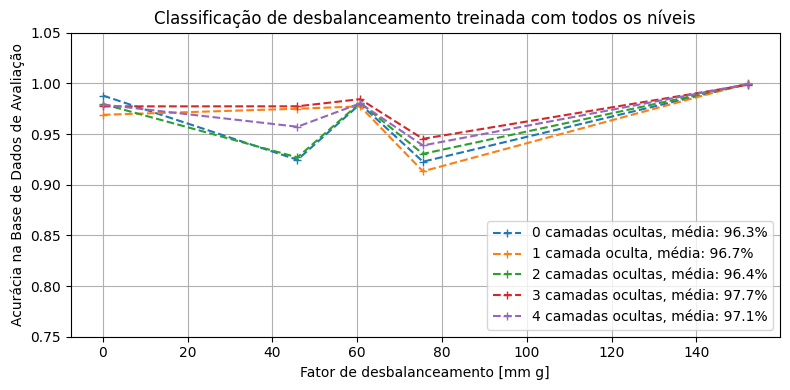

In [ ]:
fig=plt.figure(figsize=(8,4))
ax1=plt.subplot(111, title = "Classificação de desbalanceamento treinada com todos os níveis")
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[0,:,1], label=f"0 camadas ocultas, média: {100.0*np.mean(np.array(accuracies_per_class)[0,:,1]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[1,:,1], label=f"1 camada oculta, média: {100.0*np.mean(np.array(accuracies_per_class)[1,:,1]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[2,:,1], label=f"2 camadas ocultas, média: {100.0*np.mean(np.array(accuracies_per_class)[2,:,1]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[3,:,1], label=f"3 camadas ocultas, média: {100.0*np.mean(np.array(accuracies_per_class)[3,:,1]):.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, np.array(accuracies_per_class)[4,:,1], label=f"4 camadas ocultas, média: {100.0*np.mean(np.array(accuracies_per_class)[4,:,1]):.1f}%", marker="+", ls="--")
plt.ylabel("Acurácia na Base de Dados de Avaliação")
plt.xlabel("Fator de desbalanceamento [mm g]")
plt.legend(loc="lower right")
plt.ylim([0.75, 1.05])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import mode

def v2rpm(v):
    return 212*v + 209

# 3s ramp up
fade_in = np.arange(0.0, 4.0, 4.0/(3*4096))
# complete voltage sweep
measurement_circle = np.repeat(np.arange(4.0, 8.2, 0.1), 4096*20.0)
# measurement: start-up + 2 voltage sweeps
measurement = np.concatenate([fade_in, np.tile(measurement_circle,3)])
# select the data as actually used
measurement1 = measurement[50000:]
measurement1 = measurement1[:int(len(measurement1)/4096)*4096].reshape(-1,4096)
voltages_measurement = mode(measurement1, axis=1)[0]
voltages_used = np.concatenate([voltages_measurement[:len(X_val_fft_1)],
                                voltages_measurement[:len(X_val_fft_2)],
                                voltages_measurement[:len(X_val_fft_3)],
                                voltages_measurement[:len(X_val_fft_4)],
                                voltages_measurement[:len(X_val_fft_5)]])
rpms_used = v2rpm(voltages_used)

In [ ]:
rpm_borders = np.arange(1050, 1975, 25)
errors_per_rpm_range0 = []
errors_per_rpm_range1 = []
errors_per_rpm_range2 = []
errors_per_rpm_range3 = []
errors_per_rpm_range4 = []
for i in range(len(rpm_borders)-1):
    eval_inds = np.where((rpms_used>rpm_borders[i])&(rpms_used<rpm_borders[i+1]))[0]
    errors_per_rpm_range0.append(
        1-np.mean(np.abs(np.int32(model0.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range1.append(
        1-np.mean(np.abs(np.int32(model1.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range2.append(
        1-np.mean(np.abs(np.int32(model2.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range3.append(
        1-np.mean(np.abs(np.int32(model3.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))
    errors_per_rpm_range4.append(
        1-np.mean(np.abs(np.int32(model4.predict(X_val_fft_sc[eval_inds])>0.5).reshape(-1)-y_val[eval_inds])))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/

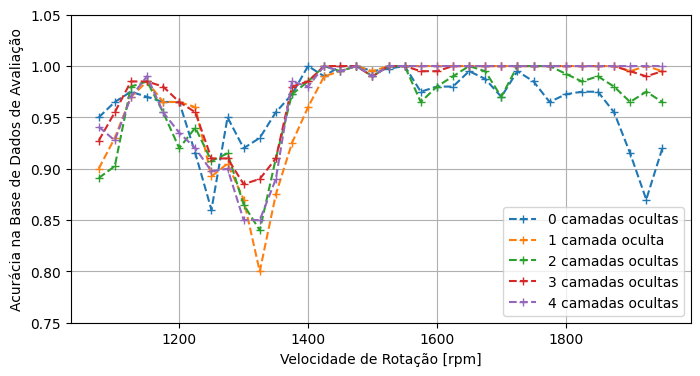

In [ ]:
fig=plt.figure(figsize=(8,4))
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range0, marker="+", ls="--", label="0 camadas ocultas")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range1, marker="+", ls="--", label="1 camada oculta")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range2, marker="+", ls="--", label="2 camadas ocultas")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range3, marker="+", ls="--", label="3 camadas ocultas")
plt.plot(np.array(rpm_borders[:-1])+25, errors_per_rpm_range4, marker="+", ls="--", label="4 camadas ocultas")
plt.ylabel("Acurácia na Base de Dados de Avaliação")
plt.xlabel("Velocidade de Rotação [rpm]")
plt.legend(loc="lower right")
plt.ylim([0.75, 1.05])
plt.grid(True)
plt.show()

## Treinamento e avaliação Par a Par

Treinamento utilizando pares da Base de Dados. Número de camadas ocultasvariando de 0 a 4.

In [ ]:
X_dev = [X0, X1, X2, X3, X4]
y_dev = [y0, y1, y2, y3, y4]

X_val_separated = [X_val_fft_1, X_val_fft_2, X_val_fft_3, X_val_fft_4, X_val_fft_5]
y_val_separated = [y_val_1, y_val_2, y_val_3, y_val_4, y_val_5]

In [ ]:
print(X_val_fft_1.shape, y_val_1.shape)

(1682, 2048) (1682,)


In [ ]:
for layer_n in range(5):
    for dataset_i in range(4):
        X_dev_i = np.concatenate([X_dev[0], X_dev[dataset_i+1]])
        y_dev_i = np.concatenate([y_dev[0], y_dev[dataset_i+1]])
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])

        train_test_ratio = 0.9
        X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
            X_dev_i,y_dev_i, test_size = 1-train_test_ratio, random_state = 0)

        #Dominio da Frequencia
        if SinaldeEntrada == 'FrequencyDomain':
          if(janelamento):
            janela_hamming = np.hamming(window)
            X_train_i = X_train_i*janela_hamming
            X_test_i = X_test_i*janela_hamming
          X_train_fft_i = np.abs(np.fft.rfft(X_train_i, axis=1))[:,:int(window/2)]
          X_test_fft_i = np.abs(np.fft.rfft(X_test_i, axis=1))[:,:int(window/2)]
          X_train_fft_i[:,0]=0
          X_test_fft_i[:,0]=0

        #Dominio do Tempo
        if SinaldeEntrada == 'TimeDomain':
          X_train_fft_i = X_train_i
          X_test_fft_i = X_test_i

        #Envelope Spectrum
        if SinaldeEntrada == 'EnvelopeSpectrum':
          X_train_fft_i = np.abs(np.fft.rfft(np.abs(signal.hilbert(X_train_i, axis=1))))[:,:int(window/2)]
          X_test_fft_i = np.abs(np.fft.rfft(np.abs(signal.hilbert(X_test_i, axis=1))))[:,:int(window/2)]

        scaler = RobustScaler(quantile_range=(5,95)).fit(X_train_fft_i)
        X_train_fft_sc_i = scaler.transform(X_train_fft_i)
        X_test_fft_sc_i = scaler.transform(X_test_fft_i)

        if not use_reference_models:
            weight_for_0 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==0]))
            weight_for_1 = len(y_dev_i)/(2*len(y_dev_i[y_dev_i==1]))
            class_weight = {0: weight_for_0, 1: weight_for_1}

            X_in = Input(shape=(X_train_fft_i.shape[1],), name="cam_layer")
            previous_layer = X_in
            for j in range(layer_n):
                x = Dense(units = 1024, activation="linear")(previous_layer)
                x = LeakyReLU(alpha=0.05)(x)
                previous_layer = x
            X_out = Dense(units = 1, activation = 'sigmoid')(previous_layer)
            model_i = Model(X_in, X_out)

            best_model_filepath = f"{model_path}_fft_fcn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
            checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                         verbose=1, save_best_only=True, mode='min')
            model_i.compile(optimizer = Adam(learning_rate=0.0005), loss = 'binary_crossentropy',
                            metrics = ['accuracy'])
            model_i.summary()

            model_i.fit(X_train_fft_sc_i, y_train_i, epochs = 100, batch_size = 128,
                       validation_data=(X_test_fft_sc_i, y_test_i), callbacks=[checkpoint],
                        class_weight=class_weight)

        #best_model_filepath = f"{model_path}/fft_fcn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
        model_i = load_model(best_model_filepath)
        train_acc = model_i.evaluate(X_train_fft_sc_i, y_train_i)
        val_acc = model_i.evaluate(X_val_i, y_val_i)
        print(f"Layers: {layer_n}, dataset pair {dataset_i}")
        print(train_acc)
        print(val_acc)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7422 - loss: 0.7311
Epoch 1: val_loss improved from inf to 0.35886, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7431 - loss: 0.7306 - val_accuracy: 0.9171 - val_loss: 0.3589
Epoch 2/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8931 - loss: 0.3891
Epoch 2: val_loss improved from 0.35886 to 0.32979, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8930 - loss: 0.3944 - val_accuracy: 0.9085 - val_loss: 0.3298
Epoch 3/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8862 - loss: 0.3247
Epoch 3: val_loss improved from 0.32979 to 0.26206, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8874 - loss: 0.3278 - val_accuracy: 0.9225 - val_loss: 0.2621
Epoch 4/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9101 - loss: 0.2767
Epoch 4: val_loss did not improve from 0.26206
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9096 - loss: 0.2830 - val_accuracy: 0.9434 - val_loss: 0.2816
Epoch 5/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9107 - loss: 0.2719
Epoch 5: val_loss improved from 0.26206 to 0.22946, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9096 - loss: 0.2758 - val_accuracy: 0.9403 - val_loss: 0.2295
Epoch 6/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2874
Epoch 6: val_loss did not improve from 0.22946
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9269 - loss: 0.2896 - val_accuracy: 0.9527 - val_loss: 0.2998
Epoch 7/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9365 - loss: 0.2357
Epoch 7: val_loss improved from 0.22946 to 0.21035, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9335 - loss: 0.2350 - val_accuracy: 0.9341 - val_loss: 0.2104
Epoch 8/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.2300
Epoch 8: val_loss did not improve from 0.21035
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9286 - loss: 0.2291 - val_accuracy: 0.9287 - val_loss: 0.2115
Epoch 9/100
68/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9249 - loss: 0.2215
Epoch 9: val_loss did not improve from 0.21035
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9253 - loss: 0.2255 - val_accuracy: 0.9457 - val_loss: 0.2399
Epoch 10/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9395 - loss: 0.2612
Epoch 10: val_loss did not improve from 0.21035
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9367 - loss: 0.2669 - val_accuracy: 0.9256 - val_loss: 0.2611
Epoch 11/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9299 - loss: 0.1998
Epoch 11: val_loss improved from 0.21035 to 0.19987, sav

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9308 - loss: 0.1997 - val_accuracy: 0.9333 - val_loss: 0.1999
Epoch 12/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9420 - loss: 0.2151
Epoch 12: val_loss improved from 0.19987 to 0.18149, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9422 - loss: 0.2295 - val_accuracy: 0.9264 - val_loss: 0.1815
Epoch 13/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9405 - loss: 0.2060
Epoch 13: val_loss did not improve from 0.18149
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9415 - loss: 0.2079 - val_accuracy: 0.9372 - val_loss: 0.2717
Epoch 14/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9360 - loss: 0.2551
Epoch 14: val_loss improved from 0.18149 to 0.16841, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9357 - loss: 0.2525 - val_accuracy: 0.9574 - val_loss: 0.1684
Epoch 15/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9529 - loss: 0.1933
Epoch 15: val_loss did not improve from 0.16841
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9492 - loss: 0.2024 - val_accuracy: 0.9411 - val_loss: 0.2821
Epoch 16/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9270 - loss: 0.2624
Epoch 16: val_loss did not improve from 0.16841
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9291 - loss: 0.2557 - val_accuracy: 0.9566 - val_loss: 0.1921
Epoch 17/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1701
Epoch 17: val_loss improved from 0.16841 to 0.15991, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9552 - loss: 0.1715 - val_accuracy: 0.9442 - val_loss: 0.1599
Epoch 18/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9470 - loss: 0.2217
Epoch 18: val_loss did not improve from 0.15991
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9487 - loss: 0.2253 - val_accuracy: 0.9535 - val_loss: 0.1627
Epoch 19/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9526 - loss: 0.1685
Epoch 19: val_loss improved from 0.15991 to 0.15691, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9535 - loss: 0.1687 - val_accuracy: 0.9333 - val_loss: 0.1569
Epoch 20/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9361 - loss: 0.2367
Epoch 20: val_loss improved from 0.15691 to 0.15106, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9399 - loss: 0.2336 - val_accuracy: 0.9473 - val_loss: 0.1511
Epoch 21/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9402 - loss: 0.2512
Epoch 21: val_loss did not improve from 0.15106
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9436 - loss: 0.2517 - val_accuracy: 0.9612 - val_loss: 0.2060
Epoch 22/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9490 - loss: 0.1725
Epoch 22: val_loss did not improve from 0.15106
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9487 - loss: 0.1777 - val_accuracy: 0.9829 - val_loss: 0.1888
Epoch 23/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9704 - loss: 0.1736
Epoch 23: val_loss did not improve from 0.15106
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9684 - loss: 0.1820 - val_accuracy: 0.9783 - val_loss: 0.2252
Epoch 24/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.1624
Epoch 24: val_loss did not improve from 0.15106
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9493 - loss: 0.1635 - val_accuracy: 0.9364 - val_loss: 0.1435
Epoch 27/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9406 - loss: 0.1836
Epoch 27: val_loss did not improve from 0.14354
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9407 - loss: 0.1918 - val_accuracy: 0.9512 - val_loss: 0.2317
Epoch 28/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9404 - loss: 0.2210
Epoch 28: val_loss did not improve from 0.14354
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9431 - loss: 0.2195 - val_accuracy: 0.9791 - val_loss: 0.2663
Epoch 29/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.1642
Epoch 29: val_loss did not improve from 0.14354
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9810 - loss: 0.1667 - val_accuracy: 0.9380 - val_loss: 0.1788
Epoch 30/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9483 - loss: 0.1948
Epoch 30: val_loss did not improve from 0.14354
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9698 - loss: 0.1442 - val_accuracy: 0.9426 - val_loss: 0.1348
Epoch 34/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9568 - loss: 0.1669
Epoch 34: val_loss did not improve from 0.13480
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9594 - loss: 0.1687 - val_accuracy: 0.9667 - val_loss: 0.2670
Epoch 35/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9611 - loss: 0.1658
Epoch 35: val_loss did not improve from 0.13480
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9615 - loss: 0.1738 - val_accuracy: 0.9736 - val_loss: 0.2515
Epoch 36/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9653 - loss: 0.1360
Epoch 36: val_loss did not improve from 0.13480
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9660 - loss: 0.1367 - val_accuracy: 0.9853 - val_loss: 0.3265
Epoch 37/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 0.1993
Epoch 37: val_loss did not improve from 0.13480
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9777 - loss: 0.1431 - val_accuracy: 0.9473 - val_loss: 0.1279
Epoch 41/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9679 - loss: 0.1449
Epoch 41: val_loss did not improve from 0.12794
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9681 - loss: 0.1449 - val_accuracy: 0.9860 - val_loss: 0.3449
Epoch 42/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9765 - loss: 0.1479
Epoch 42: val_loss improved from 0.12794 to 0.12096, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9759 - loss: 0.1492 - val_accuracy: 0.9465 - val_loss: 0.1210
Epoch 43/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9632 - loss: 0.1679
Epoch 43: val_loss did not improve from 0.12096
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9648 - loss: 0.1663 - val_accuracy: 0.9736 - val_loss: 0.2815
Epoch 44/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9652 - loss: 0.1519
Epoch 44: val_loss did not improve from 0.12096
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9641 - loss: 0.1544 - val_accuracy: 0.9752 - val_loss: 0.1329
Epoch 45/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.1268
Epoch 45: val_loss did not improve from 0.12096
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9806 - loss: 0.1285 - val_accuracy: 0.9868 - val_loss: 0.3383
Epoch 46/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9778 - loss: 0.1769
Epoch 46: val_loss did not improve from 0.12096
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9807 - loss: 0.1195 - val_accuracy: 0.9481 - val_loss: 0.1116
Epoch 55/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9575 - loss: 0.1285
Epoch 55: val_loss did not improve from 0.11155
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9609 - loss: 0.1385 - val_accuracy: 0.9922 - val_loss: 0.2555
Epoch 56/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.1101
Epoch 56: val_loss improved from 0.11155 to 0.10202, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9822 - loss: 0.1160 - val_accuracy: 0.9651 - val_loss: 0.1020
Epoch 57/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.2955
Epoch 57: val_loss improved from 0.10202 to 0.10168, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9841 - loss: 0.2671 - val_accuracy: 0.9636 - val_loss: 0.1017
Epoch 58/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9788 - loss: 0.1276
Epoch 58: val_loss did not improve from 0.10168
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9804 - loss: 0.1324 - val_accuracy: 0.9543 - val_loss: 0.1053
Epoch 59/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9667 - loss: 0.1333
Epoch 59: val_loss did not improve from 0.10168
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9674 - loss: 0.1432 - val_accuracy: 0.9853 - val_loss: 0.2893
Epoch 60/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.1205
Epoch 60: val_loss did not improve from 0.10168
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9808 - loss: 0.1256 - val_accuracy: 0.9930 - val_loss: 0.2597
Epoch 61/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9795 - loss: 0.1659
Epoch 61: val_loss did not improve from 0.10168
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9840 - loss: 0.1060 - val_accuracy: 0.9891 - val_loss: 0.0985
Epoch 83/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.1264
Epoch 83: val_loss did not improve from 0.09853
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9897 - loss: 0.1241 - val_accuracy: 0.9938 - val_loss: 0.2958
Epoch 84/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.1258
Epoch 84: val_loss improved from 0.09853 to 0.08816, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.1259 - val_accuracy: 0.9643 - val_loss: 0.0882
Epoch 85/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.1017
Epoch 85: val_loss did not improve from 0.08816
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9798 - loss: 0.1086 - val_accuracy: 0.9876 - val_loss: 0.2175
Epoch 86/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0978
Epoch 86: val_loss improved from 0.08816 to 0.08577, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9826 - loss: 0.0978 - val_accuracy: 0.9651 - val_loss: 0.0858
Epoch 87/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9741 - loss: 0.1226
Epoch 87: val_loss did not improve from 0.08577
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9757 - loss: 0.1249 - val_accuracy: 0.9829 - val_loss: 0.2516
Epoch 88/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9700 - loss: 0.1564
Epoch 88: val_loss did not improve from 0.08577
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9714 - loss: 0.1613 - val_accuracy: 0.9938 - val_loss: 0.3058
Epoch 89/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9759 - loss: 0.2862
Epoch 89: val_loss did not improve from 0.08577
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9773 - loss: 0.2518 - val_accuracy: 0.9884 - val_loss: 0.1991
Epoch 90/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0866
Epoch 90: val_loss did not improve from 0.08577
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9667 - loss: 0.1311
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9391 - loss: 0.2382
Layers: 0, dataset pair 0
[0.16392900049686432, 0.9662243723869324]
[0.2257002890110016, 0.904691219329834]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7502 - loss: 0.5663
Epoch 1: val_loss improved from inf to 0.31969, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7511 - loss: 0.5665 - val_accuracy: 0.8992 - val_loss: 0.3197
Epoch 2/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9078 - loss: 0.3736
Epoch 2: val_loss improved from 0.31969 to 0.29213, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9079 - loss: 0.3713 - val_accuracy: 0.9109 - val_loss: 0.2921
Epoch 3/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9160 - loss: 0.3508
Epoch 3: val_loss improved from 0.29213 to 0.25601, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9158 - loss: 0.3486 - val_accuracy: 0.9341 - val_loss: 0.2560
Epoch 4/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9337 - loss: 0.3172
Epoch 4: val_loss improved from 0.25601 to 0.23912, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9317 - loss: 0.3226 - val_accuracy: 0.9372 - val_loss: 0.2391
Epoch 5/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9329 - loss: 0.3016
Epoch 5: val_loss improved from 0.23912 to 0.22490, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9325 - loss: 0.3020 - val_accuracy: 0.9287 - val_loss: 0.2249
Epoch 6/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9255 - loss: 0.2433
Epoch 6: val_loss improved from 0.22490 to 0.20246, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9264 - loss: 0.2445 - val_accuracy: 0.9357 - val_loss: 0.2025
Epoch 7/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.4773
Epoch 7: val_loss improved from 0.20246 to 0.19361, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9293 - loss: 0.4416 - val_accuracy: 0.9349 - val_loss: 0.1936
Epoch 8/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9293 - loss: 0.2110
Epoch 8: val_loss did not improve from 0.19361
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9304 - loss: 0.2118 - val_accuracy: 0.9333 - val_loss: 0.2274
Epoch 9/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9347 - loss: 0.2553
Epoch 9: val_loss did not improve from 0.19361
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9352 - loss: 0.2529 - val_accuracy: 0.9388 - val_loss: 0.1979
Epoch 10/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9391 - loss: 0.1904
Epoch 10: val_loss did not improve from 0.19361
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9400 - loss: 0.1912 - val_accuracy: 0.9535 - val_loss: 0.3853
Epoch 11/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9424 - loss: 0.2516
Epoch 11: val_loss did not improve from 0.19361
91/91 ━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9379 - loss: 0.1999 - val_accuracy: 0.9465 - val_loss: 0.1607
Epoch 14/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9511 - loss: 0.1883
Epoch 14: val_loss did not improve from 0.16073
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9507 - loss: 0.1878 - val_accuracy: 0.9581 - val_loss: 0.3398
Epoch 15/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9479 - loss: 0.2895
Epoch 15: val_loss did not improve from 0.16073
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9473 - loss: 0.2834 - val_accuracy: 0.9403 - val_loss: 0.2811
Epoch 16/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9441 - loss: 0.3586
Epoch 16: val_loss did not improve from 0.16073
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9455 - loss: 0.3414 - val_accuracy: 0.9419 - val_loss: 0.2959
Epoch 17/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9433 - loss: 0.1669
Epoch 17: val_loss did not improve from 0.16073
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9752 - loss: 0.0977 - val_accuracy: 0.9667 - val_loss: 0.1574
Epoch 81/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9759 - loss: 0.0876
Epoch 81: val_loss did not improve from 0.15736
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9769 - loss: 0.0907 - val_accuracy: 0.9946 - val_loss: 0.3163
Epoch 82/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9907 - loss: 0.0880
Epoch 82: val_loss did not improve from 0.15736
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9893 - loss: 0.0957 - val_accuracy: 0.9535 - val_loss: 0.1803
Epoch 83/100
76/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - loss: 0.2567
Epoch 83: val_loss did not improve from 0.15736
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9736 - loss: 0.2356 - val_accuracy: 0.9775 - val_loss: 0.2613
Epoch 84/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0912
Epoch 84: val_loss did not improve from 0.15736
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9657 - loss: 0.1326
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9762 - loss: 0.1828
Layers: 0, dataset pair 1
[0.16485023498535156, 0.966396689414978]
[0.17336218059062958, 0.9503419399261475]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7273 - loss: 0.7119
Epoch 1: val_loss improved from inf to 0.35965, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7280 - loss: 0.7111 - val_accuracy: 0.8364 - val_loss: 0.3597
Epoch 2/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8527 - loss: 0.5056
Epoch 2: val_loss improved from 0.35965 to 0.30430, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8531 - loss: 0.4908 - val_accuracy: 0.8736 - val_loss: 0.3043
Epoch 3/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8703 - loss: 0.3417
Epoch 3: val_loss improved from 0.30430 to 0.28959, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8718 - loss: 0.3438 - val_accuracy: 0.8837 - val_loss: 0.2896
Epoch 4/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8694 - loss: 0.3301
Epoch 4: val_loss improved from 0.28959 to 0.26945, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8706 - loss: 0.3333 - val_accuracy: 0.8876 - val_loss: 0.2695
Epoch 5/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8832 - loss: 0.2969
Epoch 5: val_loss did not improve from 0.26945
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8837 - loss: 0.3094 - val_accuracy: 0.8806 - val_loss: 0.2755
Epoch 6/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8854 - loss: 0.2726
Epoch 6: val_loss improved from 0.26945 to 0.26466, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8872 - loss: 0.2718 - val_accuracy: 0.9271 - val_loss: 0.2647
Epoch 7/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9118 - loss: 0.2582
Epoch 7: val_loss improved from 0.26466 to 0.24339, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9110 - loss: 0.2593 - val_accuracy: 0.9008 - val_loss: 0.2434
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9119 - loss: 0.3335
Epoch 8: val_loss improved from 0.24339 to 0.23272, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9119 - loss: 0.3332 - val_accuracy: 0.9178 - val_loss: 0.2327
Epoch 9/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9093 - loss: 0.3739
Epoch 9: val_loss did not improve from 0.23272
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9094 - loss: 0.3674 - val_accuracy: 0.9349 - val_loss: 0.2472
Epoch 10/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9242 - loss: 0.2963
Epoch 10: val_loss improved from 0.23272 to 0.22313, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9240 - loss: 0.2960 - val_accuracy: 0.9147 - val_loss: 0.2231
Epoch 11/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9188 - loss: 0.2299
Epoch 11: val_loss did not improve from 0.22313
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9188 - loss: 0.2299 - val_accuracy: 0.9101 - val_loss: 0.2262
Epoch 12/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9108 - loss: 0.2666
Epoch 12: val_loss improved from 0.22313 to 0.22108, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9121 - loss: 0.2711 - val_accuracy: 0.9302 - val_loss: 0.2211
Epoch 13/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9239 - loss: 0.2346
Epoch 13: val_loss improved from 0.22108 to 0.20968, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9232 - loss: 0.2405 - val_accuracy: 0.9287 - val_loss: 0.2097
Epoch 14/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9303 - loss: 0.2176
Epoch 14: val_loss improved from 0.20968 to 0.20892, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9290 - loss: 0.2185 - val_accuracy: 0.9202 - val_loss: 0.2089
Epoch 15/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2596
Epoch 15: val_loss improved from 0.20892 to 0.20505, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9286 - loss: 0.2642 - val_accuracy: 0.9240 - val_loss: 0.2051
Epoch 16/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9236 - loss: 0.2082
Epoch 16: val_loss did not improve from 0.20505
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9246 - loss: 0.2132 - val_accuracy: 0.9039 - val_loss: 0.2364
Epoch 17/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9198 - loss: 0.4400
Epoch 17: val_loss improved from 0.20505 to 0.19749, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9211 - loss: 0.4002 - val_accuracy: 0.9240 - val_loss: 0.1975
Epoch 18/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9326 - loss: 0.2499
Epoch 18: val_loss did not improve from 0.19749
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9324 - loss: 0.2587 - val_accuracy: 0.9333 - val_loss: 0.1996
Epoch 19/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9352 - loss: 0.2785
Epoch 19: val_loss improved from 0.19749 to 0.19722, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9346 - loss: 0.2743 - val_accuracy: 0.9318 - val_loss: 0.1972
Epoch 20/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9360 - loss: 0.2127
Epoch 20: val_loss did not improve from 0.19722
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9343 - loss: 0.2233 - val_accuracy: 0.9031 - val_loss: 0.2227
Epoch 21/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9329 - loss: 0.2263
Epoch 21: val_loss improved from 0.19722 to 0.19476, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9326 - loss: 0.2274 - val_accuracy: 0.9434 - val_loss: 0.1948
Epoch 22/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9499 - loss: 0.2249
Epoch 22: val_loss improved from 0.19476 to 0.19020, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9477 - loss: 0.2279 - val_accuracy: 0.9240 - val_loss: 0.1902
Epoch 23/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9279 - loss: 0.2598
Epoch 23: val_loss improved from 0.19020 to 0.18579, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9298 - loss: 0.2576 - val_accuracy: 0.9264 - val_loss: 0.1858
Epoch 24/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9298 - loss: 0.1987
Epoch 24: val_loss did not improve from 0.18579
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9307 - loss: 0.1968 - val_accuracy: 0.9302 - val_loss: 0.1868
Epoch 25/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9317 - loss: 0.2711
Epoch 25: val_loss did not improve from 0.18579
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9321 - loss: 0.2685 - val_accuracy: 0.9419 - val_loss: 0.1899
Epoch 26/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.2291
Epoch 26: val_loss improved from 0.18579 to 0.17583, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9372 - loss: 0.2309 - val_accuracy: 0.9341 - val_loss: 0.1758
Epoch 27/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9400 - loss: 0.1949
Epoch 27: val_loss did not improve from 0.17583
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9403 - loss: 0.1942 - val_accuracy: 0.9279 - val_loss: 0.1831
Epoch 28/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9377 - loss: 0.1824
Epoch 28: val_loss did not improve from 0.17583
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9373 - loss: 0.1932 - val_accuracy: 0.9403 - val_loss: 0.1761
Epoch 29/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9441 - loss: 0.2049
Epoch 29: val_loss improved from 0.17583 to 0.17126, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9437 - loss: 0.2053 - val_accuracy: 0.9341 - val_loss: 0.1713
Epoch 30/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9434 - loss: 0.2153
Epoch 30: val_loss did not improve from 0.17126
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9428 - loss: 0.2142 - val_accuracy: 0.9240 - val_loss: 0.1822
Epoch 31/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9330 - loss: 0.1944
Epoch 31: val_loss improved from 0.17126 to 0.17065, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9343 - loss: 0.1962 - val_accuracy: 0.9341 - val_loss: 0.1707
Epoch 32/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9410 - loss: 0.1676
Epoch 32: val_loss did not improve from 0.17065
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9406 - loss: 0.1686 - val_accuracy: 0.9279 - val_loss: 0.1732
Epoch 33/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9374 - loss: 0.2312
Epoch 33: val_loss did not improve from 0.17065
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9386 - loss: 0.2324 - val_accuracy: 0.9240 - val_loss: 0.1783
Epoch 34/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9324 - loss: 0.1746
Epoch 34: val_loss improved from 0.17065 to 0.16684, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9332 - loss: 0.1854 - val_accuracy: 0.9357 - val_loss: 0.1668
Epoch 35/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.1613
Epoch 35: val_loss improved from 0.16684 to 0.16544, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9413 - loss: 0.1634 - val_accuracy: 0.9364 - val_loss: 0.1654
Epoch 36/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9454 - loss: 0.2340
Epoch 36: val_loss did not improve from 0.16544
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9451 - loss: 0.2373 - val_accuracy: 0.9279 - val_loss: 0.1702
Epoch 37/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.1777
Epoch 37: val_loss did not improve from 0.16544
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9389 - loss: 0.1779 - val_accuracy: 0.9295 - val_loss: 0.1656
Epoch 38/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9404 - loss: 0.2040
Epoch 38: val_loss improved from 0.16544 to 0.16521, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9406 - loss: 0.2075 - val_accuracy: 0.9341 - val_loss: 0.1652
Epoch 39/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9417 - loss: 0.1620
Epoch 39: val_loss improved from 0.16521 to 0.15901, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9408 - loss: 0.1668 - val_accuracy: 0.9364 - val_loss: 0.1590
Epoch 40/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9479 - loss: 0.1802
Epoch 40: val_loss did not improve from 0.15901
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9480 - loss: 0.1801 - val_accuracy: 0.9388 - val_loss: 0.1619
Epoch 41/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9453 - loss: 0.1542
Epoch 41: val_loss did not improve from 0.15901
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9444 - loss: 0.1566 - val_accuracy: 0.9302 - val_loss: 0.1605
Epoch 42/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9411 - loss: 0.3240
Epoch 42: val_loss improved from 0.15901 to 0.15756, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9404 - loss: 0.3004 - val_accuracy: 0.9326 - val_loss: 0.1576
Epoch 43/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9445 - loss: 0.2442
Epoch 43: val_loss improved from 0.15756 to 0.15482, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9445 - loss: 0.2441 - val_accuracy: 0.9372 - val_loss: 0.1548
Epoch 44/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1618
Epoch 44: val_loss did not improve from 0.15482
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9437 - loss: 0.1660 - val_accuracy: 0.9488 - val_loss: 0.1627
Epoch 45/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9431 - loss: 0.2123
Epoch 45: val_loss did not improve from 0.15482
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9431 - loss: 0.2128 - val_accuracy: 0.9496 - val_loss: 0.1598
Epoch 46/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9503 - loss: 0.2473
Epoch 46: val_loss did not improve from 0.15482
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9494 - loss: 0.2403 - val_accuracy: 0.9512 - val_loss: 0.1639
Epoch 47/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9474 - loss: 0.1730
Epoch 47: val_loss improved from 0.15482 to 0.15184,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9457 - loss: 0.1802 - val_accuracy: 0.9341 - val_loss: 0.1518
Epoch 48/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9458 - loss: 0.1748
Epoch 48: val_loss did not improve from 0.15184
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.1828 - val_accuracy: 0.9302 - val_loss: 0.1551
Epoch 49/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9418 - loss: 0.2292
Epoch 49: val_loss improved from 0.15184 to 0.14965, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9420 - loss: 0.2238 - val_accuracy: 0.9380 - val_loss: 0.1496
Epoch 50/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9457 - loss: 0.2131
Epoch 50: val_loss did not improve from 0.14965
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9452 - loss: 0.2146 - val_accuracy: 0.9543 - val_loss: 0.1528
Epoch 51/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9580 - loss: 0.2181
Epoch 51: val_loss improved from 0.14965 to 0.14888, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9559 - loss: 0.2161 - val_accuracy: 0.9357 - val_loss: 0.1489
Epoch 52/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9500 - loss: 0.1703
Epoch 52: val_loss improved from 0.14888 to 0.14815, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9499 - loss: 0.1801 - val_accuracy: 0.9349 - val_loss: 0.1482
Epoch 53/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9535 - loss: 0.1666
Epoch 53: val_loss improved from 0.14815 to 0.14795, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9528 - loss: 0.1731 - val_accuracy: 0.9364 - val_loss: 0.1480
Epoch 54/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9473 - loss: 0.1484
Epoch 54: val_loss did not improve from 0.14795
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9477 - loss: 0.1508 - val_accuracy: 0.9372 - val_loss: 0.1503
Epoch 55/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9473 - loss: 0.2011
Epoch 55: val_loss improved from 0.14795 to 0.14715, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9465 - loss: 0.1982 - val_accuracy: 0.9473 - val_loss: 0.1471
Epoch 56/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9471 - loss: 0.1938
Epoch 56: val_loss improved from 0.14715 to 0.14551, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9463 - loss: 0.1952 - val_accuracy: 0.9403 - val_loss: 0.1455
Epoch 57/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9419 - loss: 0.1563
Epoch 57: val_loss did not improve from 0.14551
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9427 - loss: 0.1690 - val_accuracy: 0.9643 - val_loss: 0.1522
Epoch 58/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9491 - loss: 0.1501
Epoch 58: val_loss did not improve from 0.14551
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9482 - loss: 0.1515 - val_accuracy: 0.9566 - val_loss: 0.1467
Epoch 59/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9620 - loss: 0.1633
Epoch 59: val_loss did not improve from 0.14551
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9624 - loss: 0.1660 - val_accuracy: 0.9310 - val_loss: 0.1539
Epoch 60/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9396 - loss: 0.1663
Epoch 60: val_loss improved from 0.14551 to 0.14172,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9402 - loss: 0.1704 - val_accuracy: 0.9372 - val_loss: 0.1417
Epoch 61/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9503 - loss: 0.2023
Epoch 61: val_loss did not improve from 0.14172
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9508 - loss: 0.2046 - val_accuracy: 0.9659 - val_loss: 0.1503
Epoch 62/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9555 - loss: 0.1455
Epoch 62: val_loss did not improve from 0.14172
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9543 - loss: 0.1480 - val_accuracy: 0.9612 - val_loss: 0.1472
Epoch 63/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9392 - loss: 0.1783
Epoch 63: val_loss did not improve from 0.14172
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9396 - loss: 0.1777 - val_accuracy: 0.9271 - val_loss: 0.1607
Epoch 64/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9358 - loss: 0.1735
Epoch 64: val_loss did not improve from 0.14172
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9440 - loss: 0.1759 - val_accuracy: 0.9357 - val_loss: 0.1384
Epoch 71/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9540 - loss: 0.1475
Epoch 71: val_loss improved from 0.13843 to 0.13572, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9544 - loss: 0.1518 - val_accuracy: 0.9465 - val_loss: 0.1357
Epoch 72/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9569 - loss: 0.1906
Epoch 72: val_loss improved from 0.13572 to 0.13467, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9553 - loss: 0.1919 - val_accuracy: 0.9411 - val_loss: 0.1347
Epoch 73/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9524 - loss: 0.1362
Epoch 73: val_loss did not improve from 0.13467
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9525 - loss: 0.1363 - val_accuracy: 0.9667 - val_loss: 0.1435
Epoch 74/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9556 - loss: 0.1536
Epoch 74: val_loss did not improve from 0.13467
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9541 - loss: 0.1580 - val_accuracy: 0.9589 - val_loss: 0.1538
Epoch 75/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9655 - loss: 0.1925
Epoch 75: val_loss improved from 0.13467 to 0.13403, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9654 - loss: 0.1924 - val_accuracy: 0.9434 - val_loss: 0.1340
Epoch 76/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9582 - loss: 0.1784
Epoch 76: val_loss did not improve from 0.13403
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9582 - loss: 0.1782 - val_accuracy: 0.9295 - val_loss: 0.1463
Epoch 77/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9452 - loss: 0.1633
Epoch 77: val_loss did not improve from 0.13403
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9458 - loss: 0.1695 - val_accuracy: 0.9481 - val_loss: 0.1349
Epoch 78/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9517 - loss: 0.1533
Epoch 78: val_loss did not improve from 0.13403
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9514 - loss: 0.1602 - val_accuracy: 0.9682 - val_loss: 0.1418
Epoch 79/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9604 - loss: 0.1360
Epoch 79: val_loss improved from 0.13403 to 0.13342,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9590 - loss: 0.1388 - val_accuracy: 0.9341 - val_loss: 0.1334
Epoch 80/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9521 - loss: 0.1349
Epoch 80: val_loss did not improve from 0.13342
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9543 - loss: 0.1411 - val_accuracy: 0.9527 - val_loss: 0.1403
Epoch 81/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9468 - loss: 0.1466
Epoch 81: val_loss improved from 0.13342 to 0.13282, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9462 - loss: 0.1549 - val_accuracy: 0.9341 - val_loss: 0.1328
Epoch 82/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9519 - loss: 0.1286
Epoch 82: val_loss did not improve from 0.13282
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9519 - loss: 0.1287 - val_accuracy: 0.9333 - val_loss: 0.1362
Epoch 83/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9451 - loss: 0.1383
Epoch 83: val_loss did not improve from 0.13282
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9457 - loss: 0.1555 - val_accuracy: 0.9419 - val_loss: 0.1602
Epoch 84/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9603 - loss: 0.2262
Epoch 84: val_loss improved from 0.13282 to 0.13231, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9603 - loss: 0.2258 - val_accuracy: 0.9341 - val_loss: 0.1323
Epoch 85/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9516 - loss: 0.2060
Epoch 85: val_loss improved from 0.13231 to 0.13015, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9520 - loss: 0.2018 - val_accuracy: 0.9527 - val_loss: 0.1302
Epoch 86/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.1384
Epoch 86: val_loss did not improve from 0.13015
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9619 - loss: 0.1408 - val_accuracy: 0.9326 - val_loss: 0.1417
Epoch 87/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9474 - loss: 0.1578
Epoch 87: val_loss improved from 0.13015 to 0.12842, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9473 - loss: 0.1581 - val_accuracy: 0.9419 - val_loss: 0.1284
Epoch 88/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9530 - loss: 0.1444
Epoch 88: val_loss did not improve from 0.12842
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9530 - loss: 0.1455 - val_accuracy: 0.9674 - val_loss: 0.1345
Epoch 89/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9692 - loss: 0.1467
Epoch 89: val_loss did not improve from 0.12842
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9673 - loss: 0.1518 - val_accuracy: 0.9457 - val_loss: 0.1301
Epoch 90/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9692 - loss: 0.1678
Epoch 90: val_loss improved from 0.12842 to 0.12836, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9668 - loss: 0.1730 - val_accuracy: 0.9481 - val_loss: 0.1284
Epoch 91/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.1429
Epoch 91: val_loss improved from 0.12836 to 0.12650, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9588 - loss: 0.1459 - val_accuracy: 0.9450 - val_loss: 0.1265
Epoch 92/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9557 - loss: 0.1902
Epoch 92: val_loss did not improve from 0.12650
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1900 - val_accuracy: 0.9791 - val_loss: 0.1375
Epoch 93/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9616 - loss: 0.1658
Epoch 93: val_loss did not improve from 0.12650
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9600 - loss: 0.1635 - val_accuracy: 0.9481 - val_loss: 0.1329
Epoch 94/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9529 - loss: 0.1680
Epoch 94: val_loss did not improve from 0.12650
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9523 - loss: 0.1714 - val_accuracy: 0.9357 - val_loss: 0.1322
Epoch 95/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9554 - loss: 0.1434
Epoch 95: val_loss improved from 0.12650 to 0.12569,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9535 - loss: 0.1502 - val_accuracy: 0.9581 - val_loss: 0.1257
Epoch 96/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9647 - loss: 0.1213
Epoch 96: val_loss did not improve from 0.12569
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9640 - loss: 0.1214 - val_accuracy: 0.9744 - val_loss: 0.1374
Epoch 97/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9673 - loss: 0.1803
Epoch 97: val_loss did not improve from 0.12569
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9659 - loss: 0.1838 - val_accuracy: 0.9690 - val_loss: 0.1338
Epoch 98/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9636 - loss: 0.2021
Epoch 98: val_loss did not improve from 0.12569
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9640 - loss: 0.1959 - val_accuracy: 0.9512 - val_loss: 0.1258
Epoch 99/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.1862
Epoch 99: val_loss did not improve from 0.12569
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9663 - loss: 0.1743 - val_accuracy: 0.9504 - val_loss: 0.1238


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9580 - loss: 0.1466
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8998 - loss: 0.3728
Layers: 0, dataset pair 2
[0.1711258739233017, 0.9580245018005371]
[0.872407853603363, 0.6660724878311157]


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7915 - loss: 0.5068
Epoch 1: val_loss improved from inf to 0.30202, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7922 - loss: 0.5059 - val_accuracy: 0.9403 - val_loss: 0.3020
Epoch 2/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9009 - loss: 0.2925
Epoch 2: val_loss improved from 0.30202 to 0.23215, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9006 - loss: 0.2927 - val_accuracy: 0.9140 - val_loss: 0.2322
Epoch 3/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9131 - loss: 0.2330
Epoch 3: val_loss improved from 0.23215 to 0.20963, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9141 - loss: 0.2323 - val_accuracy: 0.9085 - val_loss: 0.2096
Epoch 4/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9187 - loss: 0.2362
Epoch 4: val_loss improved from 0.20963 to 0.19021, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9191 - loss: 0.2361 - val_accuracy: 0.9124 - val_loss: 0.1902
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9118 - loss: 0.2113
Epoch 5: val_loss improved from 0.19021 to 0.17214, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9124 - loss: 0.2114 - val_accuracy: 0.9504 - val_loss: 0.1721
Epoch 6/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9435 - loss: 0.1714
Epoch 6: val_loss improved from 0.17214 to 0.15724, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9424 - loss: 0.1718 - val_accuracy: 0.9380 - val_loss: 0.1572
Epoch 7/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1725
Epoch 7: val_loss improved from 0.15724 to 0.14800, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9594 - loss: 0.1729 - val_accuracy: 0.9411 - val_loss: 0.1480
Epoch 8/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9405 - loss: 0.1680
Epoch 8: val_loss did not improve from 0.14800
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9404 - loss: 0.1684 - val_accuracy: 0.9248 - val_loss: 0.1521
Epoch 9/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9570 - loss: 0.1717
Epoch 9: val_loss improved from 0.14800 to 0.13556, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9567 - loss: 0.1707 - val_accuracy: 0.9581 - val_loss: 0.1356
Epoch 10/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9724 - loss: 0.1549
Epoch 10: val_loss improved from 0.13556 to 0.13344, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9725 - loss: 0.1531 - val_accuracy: 0.9636 - val_loss: 0.1334
Epoch 11/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.1556
Epoch 11: val_loss improved from 0.13344 to 0.12759, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9558 - loss: 0.1594 - val_accuracy: 0.9442 - val_loss: 0.1276
Epoch 12/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9593 - loss: 0.1427
Epoch 12: val_loss improved from 0.12759 to 0.12531, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9606 - loss: 0.1425 - val_accuracy: 0.9574 - val_loss: 0.1253
Epoch 13/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9456 - loss: 0.1635
Epoch 13: val_loss did not improve from 0.12531
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9461 - loss: 0.1620 - val_accuracy: 0.9845 - val_loss: 0.1446
Epoch 14/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9694 - loss: 0.1923
Epoch 14: val_loss improved from 0.12531 to 0.11939, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.1871 - val_accuracy: 0.9814 - val_loss: 0.1194
Epoch 15/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9819 - loss: 0.1166
Epoch 15: val_loss did not improve from 0.11939
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9792 - loss: 0.1197 - val_accuracy: 0.9341 - val_loss: 0.1300
Epoch 16/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9498 - loss: 0.1343
Epoch 16: val_loss improved from 0.11939 to 0.11011, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9538 - loss: 0.1345 - val_accuracy: 0.9752 - val_loss: 0.1101
Epoch 17/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9707 - loss: 0.1120
Epoch 17: val_loss improved from 0.11011 to 0.10529, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 0.1140 - val_accuracy: 0.9783 - val_loss: 0.1053
Epoch 18/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.1108
Epoch 18: val_loss did not improve from 0.10529
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9782 - loss: 0.1139 - val_accuracy: 0.9760 - val_loss: 0.1072
Epoch 19/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.1157
Epoch 19: val_loss improved from 0.10529 to 0.10111, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9743 - loss: 0.1204 - val_accuracy: 0.9690 - val_loss: 0.1011
Epoch 20/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9786 - loss: 0.1235
Epoch 20: val_loss improved from 0.10111 to 0.09887, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9779 - loss: 0.1222 - val_accuracy: 0.9760 - val_loss: 0.0989
Epoch 21/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9714 - loss: 0.1087
Epoch 21: val_loss improved from 0.09887 to 0.09597, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9713 - loss: 0.1103 - val_accuracy: 0.9791 - val_loss: 0.0960
Epoch 22/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.1950
Epoch 22: val_loss did not improve from 0.09597
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - loss: 0.1802 - val_accuracy: 0.9620 - val_loss: 0.0975
Epoch 23/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9739 - loss: 0.1179
Epoch 23: val_loss improved from 0.09597 to 0.09204, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9738 - loss: 0.1179 - val_accuracy: 0.9760 - val_loss: 0.0920
Epoch 24/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.1374
Epoch 24: val_loss did not improve from 0.09204
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9822 - loss: 0.1358 - val_accuracy: 0.9620 - val_loss: 0.0955
Epoch 25/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9685 - loss: 0.1152
Epoch 25: val_loss did not improve from 0.09204
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9687 - loss: 0.1152 - val_accuracy: 0.9969 - val_loss: 0.1006
Epoch 26/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0954
Epoch 26: val_loss improved from 0.09204 to 0.08878, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9874 - loss: 0.0957 - val_accuracy: 0.9752 - val_loss: 0.0888
Epoch 27/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9805 - loss: 0.1445
Epoch 27: val_loss did not improve from 0.08878
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.1409 - val_accuracy: 0.9674 - val_loss: 0.0926
Epoch 28/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0896
Epoch 28: val_loss improved from 0.08878 to 0.08753, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9780 - loss: 0.0906 - val_accuracy: 0.9690 - val_loss: 0.0875
Epoch 29/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9828 - loss: 0.1090
Epoch 29: val_loss did not improve from 0.08753
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9831 - loss: 0.1084 - val_accuracy: 0.9674 - val_loss: 0.0893
Epoch 30/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9660 - loss: 0.1430
Epoch 30: val_loss improved from 0.08753 to 0.08420, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9661 - loss: 0.1425 - val_accuracy: 0.9884 - val_loss: 0.0842
Epoch 31/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9896 - loss: 0.0882
Epoch 31: val_loss improved from 0.08420 to 0.08243, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9896 - loss: 0.0881 - val_accuracy: 0.9729 - val_loss: 0.0824
Epoch 32/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9776 - loss: 0.0847
Epoch 32: val_loss did not improve from 0.08243
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9776 - loss: 0.0881 - val_accuracy: 0.9922 - val_loss: 0.1009
Epoch 33/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.1278
Epoch 33: val_loss improved from 0.08243 to 0.07794, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9822 - loss: 0.1266 - val_accuracy: 0.9860 - val_loss: 0.0779
Epoch 34/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.1093
Epoch 34: val_loss did not improve from 0.07794
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.1065 - val_accuracy: 0.9977 - val_loss: 0.0867
Epoch 35/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0899
Epoch 35: val_loss did not improve from 0.07794
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9898 - loss: 0.0917 - val_accuracy: 0.9969 - val_loss: 0.0874
Epoch 36/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.1297
Epoch 36: val_loss improved from 0.07794 to 0.07507, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9861 - loss: 0.1254 - val_accuracy: 0.9814 - val_loss: 0.0751
Epoch 37/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0766
Epoch 37: val_loss did not improve from 0.07507
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9821 - loss: 0.0832 - val_accuracy: 0.9930 - val_loss: 0.0760
Epoch 38/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9858 - loss: 0.1149
Epoch 38: val_loss did not improve from 0.07507
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.1123 - val_accuracy: 0.9822 - val_loss: 0.0756
Epoch 39/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0718
Epoch 39: val_loss did not improve from 0.07507
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9835 - loss: 0.0751 - val_accuracy: 0.9496 - val_loss: 0.0913
Epoch 40/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.1736
Epoch 40: val_loss improved from 0.07507 to 0.07208,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9733 - loss: 0.1588 - val_accuracy: 0.9783 - val_loss: 0.0721
Epoch 41/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9801 - loss: 0.0800
Epoch 41: val_loss improved from 0.07208 to 0.06967, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9799 - loss: 0.0821 - val_accuracy: 0.9884 - val_loss: 0.0697
Epoch 42/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0916
Epoch 42: val_loss did not improve from 0.06967
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9878 - loss: 0.0951 - val_accuracy: 0.9961 - val_loss: 0.0731
Epoch 43/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0752
Epoch 43: val_loss improved from 0.06967 to 0.06882, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9915 - loss: 0.0761 - val_accuracy: 0.9798 - val_loss: 0.0688
Epoch 44/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9847 - loss: 0.1142
Epoch 44: val_loss did not improve from 0.06882
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9851 - loss: 0.1083 - val_accuracy: 0.9651 - val_loss: 0.0802
Epoch 45/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.1855
Epoch 45: val_loss improved from 0.06882 to 0.06666, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9746 - loss: 0.1730 - val_accuracy: 0.9806 - val_loss: 0.0667
Epoch 46/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0892
Epoch 46: val_loss did not improve from 0.06666
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9863 - loss: 0.0896 - val_accuracy: 0.9907 - val_loss: 0.0684
Epoch 47/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0953
Epoch 47: val_loss did not improve from 0.06666
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9840 - loss: 0.0964 - val_accuracy: 0.9969 - val_loss: 0.0704
Epoch 48/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0719
Epoch 48: val_loss improved from 0.06666 to 0.06445, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.0757 - val_accuracy: 0.9891 - val_loss: 0.0644
Epoch 49/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.0910
Epoch 49: val_loss improved from 0.06445 to 0.06383, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9841 - loss: 0.0931 - val_accuracy: 0.9829 - val_loss: 0.0638
Epoch 50/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0725
Epoch 50: val_loss did not improve from 0.06383
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9943 - loss: 0.0728 - val_accuracy: 0.9752 - val_loss: 0.0690
Epoch 51/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 0.0663
Epoch 51: val_loss did not improve from 0.06383
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9791 - loss: 0.0664 - val_accuracy: 0.9775 - val_loss: 0.0667
Epoch 52/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.1164
Epoch 52: val_loss did not improve from 0.06383
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9858 - loss: 0.1144 - val_accuracy: 0.9783 - val_loss: 0.0648
Epoch 53/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0829
Epoch 53: val_loss improved from 0.06383 to 0.06215,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9837 - loss: 0.0813 - val_accuracy: 0.9829 - val_loss: 0.0621
Epoch 54/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0636
Epoch 54: val_loss did not improve from 0.06215
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9870 - loss: 0.0633 - val_accuracy: 0.9698 - val_loss: 0.0715
Epoch 55/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9767 - loss: 0.1421
Epoch 55: val_loss improved from 0.06215 to 0.06051, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9788 - loss: 0.1375 - val_accuracy: 0.9938 - val_loss: 0.0605
Epoch 56/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0893
Epoch 56: val_loss did not improve from 0.06051
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0871 - val_accuracy: 0.9837 - val_loss: 0.0617
Epoch 57/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0766
Epoch 57: val_loss improved from 0.06051 to 0.05869, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0782 - val_accuracy: 0.9860 - val_loss: 0.0587
Epoch 58/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0605
Epoch 58: val_loss did not improve from 0.05869
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9886 - loss: 0.0605 - val_accuracy: 0.9798 - val_loss: 0.0607
Epoch 59/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.2180
Epoch 59: val_loss improved from 0.05869 to 0.05863, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9855 - loss: 0.1948 - val_accuracy: 0.9853 - val_loss: 0.0586
Epoch 60/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9902 - loss: 0.0590
Epoch 60: val_loss did not improve from 0.05863
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9892 - loss: 0.0618 - val_accuracy: 0.9977 - val_loss: 0.0619
Epoch 61/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0801
Epoch 61: val_loss did not improve from 0.05863
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0809 - val_accuracy: 0.9729 - val_loss: 0.0673
Epoch 62/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9783 - loss: 0.0671
Epoch 62: val_loss improved from 0.05863 to 0.05766, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9787 - loss: 0.0699 - val_accuracy: 0.9953 - val_loss: 0.0577
Epoch 63/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9800 - loss: 0.0914
Epoch 63: val_loss did not improve from 0.05766
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9802 - loss: 0.0904 - val_accuracy: 0.9837 - val_loss: 0.0583
Epoch 64/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9844 - loss: 0.1236
Epoch 64: val_loss did not improve from 0.05766
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9850 - loss: 0.1168 - val_accuracy: 0.9930 - val_loss: 0.0600
Epoch 65/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0672
Epoch 65: val_loss improved from 0.05766 to 0.05422, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9909 - loss: 0.0725 - val_accuracy: 0.9891 - val_loss: 0.0542
Epoch 66/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0793
Epoch 66: val_loss improved from 0.05422 to 0.05380, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0843 - val_accuracy: 0.9899 - val_loss: 0.0538
Epoch 67/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0725
Epoch 67: val_loss did not improve from 0.05380
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9933 - loss: 0.0728 - val_accuracy: 0.9837 - val_loss: 0.0560
Epoch 68/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0546
Epoch 68: val_loss did not improve from 0.05380
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9883 - loss: 0.0568 - val_accuracy: 0.9946 - val_loss: 0.0539
Epoch 69/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0747
Epoch 69: val_loss did not improve from 0.05380
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9931 - loss: 0.0795 - val_accuracy: 0.9729 - val_loss: 0.0647
Epoch 70/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9836 - loss: 0.0619
Epoch 70: val_loss did not improve from 0.05380
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9843 - loss: 0.0605 - val_accuracy: 0.9915 - val_loss: 0.0516
Epoch 73/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0638
Epoch 73: val_loss did not improve from 0.05159
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0716 - val_accuracy: 0.9946 - val_loss: 0.0516
Epoch 74/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0771
Epoch 74: val_loss did not improve from 0.05159
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9939 - loss: 0.0772 - val_accuracy: 0.9744 - val_loss: 0.0618
Epoch 75/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.0881
Epoch 75: val_loss did not improve from 0.05159
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9859 - loss: 0.0821 - val_accuracy: 0.9938 - val_loss: 0.0541
Epoch 76/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0527
Epoch 76: val_loss improved from 0.05159 to 0.05013,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9940 - loss: 0.0566 - val_accuracy: 0.9884 - val_loss: 0.0501
Epoch 77/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0670
Epoch 77: val_loss did not improve from 0.05013
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9938 - loss: 0.0717 - val_accuracy: 0.9752 - val_loss: 0.0605
Epoch 78/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0986
Epoch 78: val_loss did not improve from 0.05013
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9864 - loss: 0.0933 - val_accuracy: 0.9791 - val_loss: 0.0552
Epoch 79/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0705
Epoch 79: val_loss did not improve from 0.05013
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 0.0700 - val_accuracy: 0.9853 - val_loss: 0.0531
Epoch 80/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9816 - loss: 0.0552
Epoch 80: val_loss did not improve from 0.05013
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9947 - loss: 0.0812 - val_accuracy: 0.9930 - val_loss: 0.0489
Epoch 83/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0496
Epoch 83: val_loss improved from 0.04894 to 0.04803, saving model to ../models/reference_fft_fcn_0_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9943 - loss: 0.0553 - val_accuracy: 0.9891 - val_loss: 0.0480
Epoch 84/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0502
Epoch 84: val_loss did not improve from 0.04803
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9922 - loss: 0.0502 - val_accuracy: 0.9829 - val_loss: 0.0510
Epoch 85/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0481
Epoch 85: val_loss did not improve from 0.04803
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9905 - loss: 0.0483 - val_accuracy: 0.9829 - val_loss: 0.0501
Epoch 86/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0636
Epoch 86: val_loss did not improve from 0.04803
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 0.0638 - val_accuracy: 0.9969 - val_loss: 0.0520
Epoch 87/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 0.0997
Epoch 87: val_loss did not improve from 0.04803
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9863 - loss: 0.0530 - val_accuracy: 0.9860 - val_loss: 0.0475
Epoch 89/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.1009
Epoch 89: val_loss did not improve from 0.04750
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9802 - loss: 0.0999 - val_accuracy: 0.9992 - val_loss: 0.0516
Epoch 90/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0695
Epoch 90: val_loss did not improve from 0.04750
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0708 - val_accuracy: 0.9822 - val_loss: 0.0491
Epoch 91/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0549
Epoch 91: val_loss did not improve from 0.04750
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 0.0605 - val_accuracy: 0.9775 - val_loss: 0.0545
Epoch 92/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0631
Epoch 92: val_loss improved from 0.04750 to 0.04536,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9826 - loss: 0.0672 - val_accuracy: 0.9891 - val_loss: 0.0454
Epoch 93/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0534
Epoch 93: val_loss did not improve from 0.04536
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9960 - loss: 0.0595 - val_accuracy: 0.9860 - val_loss: 0.0457
Epoch 94/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0560
Epoch 94: val_loss did not improve from 0.04536
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9839 - loss: 0.0584 - val_accuracy: 0.9984 - val_loss: 0.0463
Epoch 95/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0565
Epoch 95: val_loss did not improve from 0.04536
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9929 - loss: 0.0570 - val_accuracy: 0.9977 - val_loss: 0.0492
Epoch 96/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0635
Epoch 96: val_loss did not improve from 0.04536
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9925 - loss: 0.0460
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9805 - loss: 0.3587
Layers: 0, dataset pair 3
[0.05026758089661598, 0.9918117523193359]
[0.10363010317087173, 0.9943603277206421]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,201 (8.01 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8065 - loss: 0.7554
Epoch 1: val_loss improved from inf to 0.12412, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8075 - loss: 0.7527 - val_accuracy: 0.9690 - val_loss: 0.1241
Epoch 2/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9693 - loss: 1.1487
Epoch 2: val_loss improved from 0.12412 to 0.07787, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9695 - loss: 1.1214 - val_accuracy: 0.9891 - val_loss: 0.0779
Epoch 3/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9541 - loss: 0.2600
Epoch 3: val_loss did not improve from 0.07787
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9546 - loss: 0.2689 - val_accuracy: 0.9674 - val_loss: 0.8023
Epoch 4/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.6412
Epoch 4: val_loss improved from 0.07787 to 0.06095, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9861 - loss: 0.6517 - val_accuracy: 0.9946 - val_loss: 0.0609
Epoch 5/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9743 - loss: 2.5587
Epoch 5: val_loss improved from 0.06095 to 0.04823, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9759 - loss: 2.2961 - val_accuracy: 0.9969 - val_loss: 0.0482
Epoch 6/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.7575
Epoch 6: val_loss did not improve from 0.04823
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.6964 - val_accuracy: 0.9891 - val_loss: 0.0539
Epoch 7/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.3361
Epoch 7: val_loss did not improve from 0.04823
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9885 - loss: 0.3316 - val_accuracy: 0.9915 - val_loss: 0.2188
Epoch 8/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.1625
Epoch 8: val_loss improved from 0.04823 to 0.03528, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9900 - loss: 0.1777 - val_accuracy: 0.9891 - val_loss: 0.0353
Epoch 9/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.2817
Epoch 9: val_loss did not improve from 0.03528
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.2437 - val_accuracy: 0.9891 - val_loss: 0.4138
Epoch 10/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0401
Epoch 10: val_loss improved from 0.03528 to 0.03462, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0452 - val_accuracy: 0.9969 - val_loss: 0.0346
Epoch 11/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.5866
Epoch 11: val_loss did not improve from 0.03462
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.6032 - val_accuracy: 0.9946 - val_loss: 0.7032
Epoch 12/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.1456
Epoch 12: val_loss did not improve from 0.03462
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.1458 - val_accuracy: 0.9946 - val_loss: 1.2637
Epoch 13/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.1198
Epoch 13: val_loss improved from 0.03462 to 0.02994, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.2065 - val_accuracy: 0.9922 - val_loss: 0.0299
Epoch 14/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.5756
Epoch 14: val_loss did not improve from 0.02994
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9948 - loss: 0.5719 - val_accuracy: 0.9791 - val_loss: 0.5057
Epoch 15/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.3278
Epoch 15: val_loss improved from 0.02994 to 0.01865, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9927 - loss: 0.3310 - val_accuracy: 0.9977 - val_loss: 0.0186
Epoch 16/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.1133
Epoch 16: val_loss did not improve from 0.01865
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9983 - loss: 0.1146 - val_accuracy: 0.9969 - val_loss: 0.3964
Epoch 17/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.1852
Epoch 17: val_loss improved from 0.01865 to 0.01657, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9978 - loss: 0.1880 - val_accuracy: 0.9977 - val_loss: 0.0166
Epoch 18/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.1277
Epoch 18: val_loss did not improve from 0.01657
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.1271 - val_accuracy: 0.9969 - val_loss: 0.0231
Epoch 19/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.6206
Epoch 19: val_loss did not improve from 0.01657
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.5683 - val_accuracy: 0.9969 - val_loss: 0.1071
Epoch 20/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0553
Epoch 20: val_loss did not improve from 0.01657
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.1039 - val_accuracy: 0.9969 - val_loss: 0.2261
Epoch 21/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0844
Epoch 21: val_loss did not improve from 0.01657
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.2249 - val_accuracy: 0.9984 - val_loss: 0.0119
Epoch 31/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0652
Epoch 31: val_loss did not improve from 0.01189
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9932 - loss: 0.0575 - val_accuracy: 0.9977 - val_loss: 0.3510
Epoch 32/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0350
Epoch 32: val_loss did not improve from 0.01189
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0417 - val_accuracy: 0.9969 - val_loss: 0.6558
Epoch 33/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.2300
Epoch 33: val_loss did not improve from 0.01189
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.2294 - val_accuracy: 0.9969 - val_loss: 0.3121
Epoch 34/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0686
Epoch 34: val_loss did not improve from 0.01189
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0101 - val_accuracy: 0.9977 - val_loss: 0.0111
Epoch 44/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0272
Epoch 44: val_loss did not improve from 0.01112
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0377 - val_accuracy: 0.9969 - val_loss: 0.2233
Epoch 45/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.2291
Epoch 45: val_loss did not improve from 0.01112
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9885 - loss: 0.2014 - val_accuracy: 0.9969 - val_loss: 0.2223
Epoch 46/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0218
Epoch 46: val_loss improved from 0.01112 to 0.01014, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0224 - val_accuracy: 0.9984 - val_loss: 0.0101
Epoch 47/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0521
Epoch 47: val_loss did not improve from 0.01014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9966 - loss: 0.0599 - val_accuracy: 0.9860 - val_loss: 0.3796
Epoch 48/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0203
Epoch 48: val_loss did not improve from 0.01014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9959 - loss: 0.0205 - val_accuracy: 0.9969 - val_loss: 0.5710
Epoch 49/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0382
Epoch 49: val_loss did not improve from 0.01014
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0385 - val_accuracy: 0.9899 - val_loss: 0.3256
Epoch 50/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0540
Epoch 50: val_loss did not improve from 0.01014
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9990 - loss: 0.0953
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9061 - loss: 2.0697
Layers: 1, dataset pair 0
[0.17214462161064148, 0.99862140417099]
[0.8125338554382324, 0.8720308542251587]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,201 (8.01 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8151 - loss: 0.5872
Epoch 1: val_loss improved from inf to 2.06448, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8159 - loss: 0.5878 - val_accuracy: 0.9233 - val_loss: 2.0645
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9546 - loss: 1.9723
Epoch 2: val_loss improved from 2.06448 to 0.91164, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9546 - loss: 1.9751 - val_accuracy: 0.9860 - val_loss: 0.9116
Epoch 3/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 4.0280
Epoch 3: val_loss improved from 0.91164 to 0.31457, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9732 - loss: 3.3524 - val_accuracy: 0.9705 - val_loss: 0.3146
Epoch 4/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9831 - loss: 0.6411
Epoch 4: val_loss improved from 0.31457 to 0.20465, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9839 - loss: 0.6728 - val_accuracy: 0.9891 - val_loss: 0.2047
Epoch 5/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.1203
Epoch 5: val_loss did not improve from 0.20465
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9913 - loss: 0.1309 - val_accuracy: 0.9961 - val_loss: 1.1219
Epoch 6/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9913 - loss: 1.5395
Epoch 6: val_loss did not improve from 0.20465
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9911 - loss: 1.4183 - val_accuracy: 0.9876 - val_loss: 0.9111
Epoch 7/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.3866
Epoch 7: val_loss improved from 0.20465 to 0.04016, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9945 - loss: 0.4207 - val_accuracy: 0.9829 - val_loss: 0.0402
Epoch 8/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.2705
Epoch 8: val_loss did not improve from 0.04016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.3006 - val_accuracy: 0.9961 - val_loss: 0.7447
Epoch 9/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 1.7300
Epoch 9: val_loss did not improve from 0.04016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9871 - loss: 1.4810 - val_accuracy: 0.9969 - val_loss: 0.3569
Epoch 10/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.4872
Epoch 10: val_loss did not improve from 0.04016
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.4550 - val_accuracy: 0.9969 - val_loss: 0.3212
Epoch 11/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.2383
Epoch 11: val_loss did not improve from 0.04016
91/91 ━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0419 - val_accuracy: 0.9969 - val_loss: 0.0215
Epoch 56/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0251
Epoch 56: val_loss did not improve from 0.02154
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9939 - loss: 0.0250 - val_accuracy: 0.9953 - val_loss: 0.5529
Epoch 57/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0110
Epoch 57: val_loss did not improve from 0.02154
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0174 - val_accuracy: 0.9977 - val_loss: 0.2607
Epoch 58/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0715
Epoch 58: val_loss did not improve from 0.02154
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0697 - val_accuracy: 0.9953 - val_loss: 0.4602
Epoch 59/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0355
Epoch 59: val_loss did not improve from 0.02154
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0249 - val_accuracy: 0.9984 - val_loss: 0.0074
Epoch 82/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.1735
Epoch 82: val_loss did not improve from 0.00735
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.1714 - val_accuracy: 0.9969 - val_loss: 0.0260
Epoch 83/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0312
Epoch 83: val_loss did not improve from 0.00735
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0310 - val_accuracy: 0.9953 - val_loss: 0.4406
Epoch 84/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.2463
Epoch 84: val_loss did not improve from 0.00735
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.2165 - val_accuracy: 0.9984 - val_loss: 0.0207
Epoch 85/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0060
Epoch 85: val_loss did not improve from 0.00735
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9992 - loss: 0.0659
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9504 - loss: 1.1574
Layers: 1, dataset pair 1
[0.10949940234422684, 0.9988799095153809]
[0.3399929702281952, 0.9637228846549988]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,201 (8.01 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7703 - loss: 1.0392
Epoch 1: val_loss improved from inf to 0.30588, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7711 - loss: 1.0397 - val_accuracy: 0.8736 - val_loss: 0.3059
Epoch 2/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9235 - loss: 0.8908
Epoch 2: val_loss improved from 0.30588 to 0.24518, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9269 - loss: 0.9176 - val_accuracy: 0.9194 - val_loss: 0.2452
Epoch 3/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9362 - loss: 0.6549
Epoch 3: val_loss improved from 0.24518 to 0.18554, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9388 - loss: 0.7648 - val_accuracy: 0.9690 - val_loss: 0.1855
Epoch 4/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9498 - loss: 1.3404
Epoch 4: val_loss did not improve from 0.18554
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9501 - loss: 1.2027 - val_accuracy: 0.9814 - val_loss: 0.1891
Epoch 5/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9637 - loss: 0.7798
Epoch 5: val_loss improved from 0.18554 to 0.17565, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9632 - loss: 0.7922 - val_accuracy: 0.9318 - val_loss: 0.1757
Epoch 6/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9423 - loss: 0.3163
Epoch 6: val_loss improved from 0.17565 to 0.16685, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9468 - loss: 0.3629 - val_accuracy: 0.9519 - val_loss: 0.1669
Epoch 7/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.2032
Epoch 7: val_loss improved from 0.16685 to 0.10007, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9721 - loss: 0.2107 - val_accuracy: 0.9767 - val_loss: 0.1001
Epoch 8/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 1.6719
Epoch 8: val_loss improved from 0.10007 to 0.07141, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9764 - loss: 1.4272 - val_accuracy: 0.9814 - val_loss: 0.0714
Epoch 9/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9845 - loss: 0.5579
Epoch 9: val_loss did not improve from 0.07141
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9847 - loss: 0.5094 - val_accuracy: 0.9667 - val_loss: 0.1056
Epoch 10/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9834 - loss: 0.0711
Epoch 10: val_loss did not improve from 0.07141
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.0848 - val_accuracy: 0.9395 - val_loss: 0.1105
Epoch 11/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9712 - loss: 0.6131
Epoch 11: val_loss did not improve from 0.07141
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9738 - loss: 0.5357 - val_accuracy: 0.9721 - val_loss: 0.0959
Epoch 12/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9875 - loss: 0.1767
Epoch 12: val_loss did not improve from 0.07141
91/91 

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9888 - loss: 0.9983 - val_accuracy: 0.9915 - val_loss: 0.0543
Epoch 15/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.3668
Epoch 15: val_loss did not improve from 0.05427
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.4131 - val_accuracy: 0.9760 - val_loss: 0.0582
Epoch 16/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9678 - loss: 0.2142
Epoch 16: val_loss did not improve from 0.05427
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9714 - loss: 0.1924 - val_accuracy: 0.9922 - val_loss: 0.0581
Epoch 17/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9793 - loss: 0.1885
Epoch 17: val_loss did not improve from 0.05427
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9787 - loss: 0.2135 - val_accuracy: 0.9240 - val_loss: 0.1650
Epoch 18/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.1990
Epoch 18: val_loss did not improve from 0.05427
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9940 - loss: 0.2855 - val_accuracy: 0.9899 - val_loss: 0.0485
Epoch 20/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.4728
Epoch 20: val_loss improved from 0.04851 to 0.03654, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9916 - loss: 0.5103 - val_accuracy: 0.9930 - val_loss: 0.0365
Epoch 21/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.7270
Epoch 21: val_loss did not improve from 0.03654
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.6339 - val_accuracy: 0.9915 - val_loss: 0.0669
Epoch 22/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0338
Epoch 22: val_loss did not improve from 0.03654
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0688 - val_accuracy: 0.9845 - val_loss: 0.0391
Epoch 23/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.6527
Epoch 23: val_loss improved from 0.03654 to 0.02710, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9921 - loss: 0.5641 - val_accuracy: 0.9946 - val_loss: 0.0271
Epoch 24/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.5731
Epoch 24: val_loss did not improve from 0.02710
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.5704 - val_accuracy: 0.9922 - val_loss: 0.0314
Epoch 25/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.5626
Epoch 25: val_loss did not improve from 0.02710
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.4828 - val_accuracy: 0.9953 - val_loss: 0.0285
Epoch 26/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.2173
Epoch 26: val_loss improved from 0.02710 to 0.02631, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9961 - loss: 0.2134 - val_accuracy: 0.9946 - val_loss: 0.0263
Epoch 27/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.1057
Epoch 27: val_loss did not improve from 0.02631
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.1115 - val_accuracy: 0.9876 - val_loss: 0.0434
Epoch 28/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.1325
Epoch 28: val_loss did not improve from 0.02631
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.1235 - val_accuracy: 0.9845 - val_loss: 0.0590
Epoch 29/100
74/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.1018
Epoch 29: val_loss improved from 0.02631 to 0.02519, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9950 - loss: 0.1069 - val_accuracy: 0.9946 - val_loss: 0.0252
Epoch 30/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0516
Epoch 30: val_loss did not improve from 0.02519
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0630 - val_accuracy: 0.9930 - val_loss: 0.0408
Epoch 31/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0214
Epoch 31: val_loss did not improve from 0.02519
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0232 - val_accuracy: 0.9907 - val_loss: 0.0436
Epoch 32/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.1944
Epoch 32: val_loss did not improve from 0.02519
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.1892 - val_accuracy: 0.9783 - val_loss: 0.0555
Epoch 33/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0500
Epoch 33: val_loss improved from 0.02519 to 0.02205,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.0725 - val_accuracy: 0.9953 - val_loss: 0.0220
Epoch 34/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0551
Epoch 34: val_loss did not improve from 0.02205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0528 - val_accuracy: 0.9953 - val_loss: 0.0299
Epoch 35/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0258
Epoch 35: val_loss did not improve from 0.02205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0264 - val_accuracy: 0.9953 - val_loss: 0.0250
Epoch 36/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0790
Epoch 36: val_loss did not improve from 0.02205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0910 - val_accuracy: 0.9946 - val_loss: 0.0327
Epoch 37/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0544
Epoch 37: val_loss did not improve from 0.02205
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9972 - loss: 0.0741 - val_accuracy: 0.9953 - val_loss: 0.0219
Epoch 42/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0241
Epoch 42: val_loss did not improve from 0.02193
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0291 - val_accuracy: 0.9938 - val_loss: 0.0370
Epoch 43/100
68/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0447
Epoch 43: val_loss did not improve from 0.02193
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0556 - val_accuracy: 0.9922 - val_loss: 0.0289
Epoch 44/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0703
Epoch 44: val_loss did not improve from 0.02193
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0749 - val_accuracy: 0.9961 - val_loss: 0.0261
Epoch 45/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0441
Epoch 45: val_loss improved from 0.02193 to 0.02147,

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0539 - val_accuracy: 0.9961 - val_loss: 0.0215
Epoch 46/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0300
Epoch 46: val_loss did not improve from 0.02147
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0304 - val_accuracy: 0.9930 - val_loss: 0.0326
Epoch 47/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0111
Epoch 47: val_loss did not improve from 0.02147
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0182 - val_accuracy: 0.9946 - val_loss: 0.0227
Epoch 48/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.1463
Epoch 48: val_loss improved from 0.02147 to 0.02135, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.1335 - val_accuracy: 0.9969 - val_loss: 0.0213
Epoch 49/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0281
Epoch 49: val_loss did not improve from 0.02135
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.0368 - val_accuracy: 0.9930 - val_loss: 0.0293
Epoch 50/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0171
Epoch 50: val_loss did not improve from 0.02135
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0187 - val_accuracy: 0.9946 - val_loss: 0.0270
Epoch 51/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0271
Epoch 51: val_loss did not improve from 0.02135
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0327 - val_accuracy: 0.9946 - val_loss: 0.0319
Epoch 52/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.1129
Epoch 52: val_loss did not improve from 0.02135
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9968 - loss: 0.0307 - val_accuracy: 0.9969 - val_loss: 0.0209
Epoch 54/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.1095
Epoch 54: val_loss did not improve from 0.02090
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9935 - loss: 0.1091 - val_accuracy: 0.9953 - val_loss: 0.0212
Epoch 55/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0248
Epoch 55: val_loss did not improve from 0.02090
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0242 - val_accuracy: 0.9961 - val_loss: 0.0340
Epoch 56/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0392
Epoch 56: val_loss did not improve from 0.02090
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0391 - val_accuracy: 0.9953 - val_loss: 0.0302
Epoch 57/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0785
Epoch 57: val_loss did not improve from 0.02090
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0245 - val_accuracy: 0.9977 - val_loss: 0.0201
Epoch 66/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.1410
Epoch 66: val_loss did not improve from 0.02008
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.1356 - val_accuracy: 0.9690 - val_loss: 0.0603
Epoch 67/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0665
Epoch 67: val_loss did not improve from 0.02008
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9958 - loss: 0.0781 - val_accuracy: 0.9930 - val_loss: 0.0217
Epoch 68/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0205
Epoch 68: val_loss did not improve from 0.02008
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0272 - val_accuracy: 0.9899 - val_loss: 0.0397
Epoch 69/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0794
Epoch 69: val_loss did not improve from 0.02008
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0111 - val_accuracy: 0.9946 - val_loss: 0.0201
Epoch 79/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0068
Epoch 79: val_loss did not improve from 0.02007
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0083 - val_accuracy: 0.9938 - val_loss: 0.0255
Epoch 80/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0257
Epoch 80: val_loss did not improve from 0.02007
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0254 - val_accuracy: 0.9922 - val_loss: 0.0312
Epoch 81/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.1789
Epoch 81: val_loss improved from 0.02007 to 0.01972, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - loss: 0.1698 - val_accuracy: 0.9938 - val_loss: 0.0197
Epoch 82/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0293
Epoch 82: val_loss did not improve from 0.01972
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.0272 - val_accuracy: 0.9946 - val_loss: 0.0254
Epoch 83/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0610
Epoch 83: val_loss did not improve from 0.01972
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9961 - loss: 0.0735 - val_accuracy: 0.9946 - val_loss: 0.0307
Epoch 84/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0684
Epoch 84: val_loss did not improve from 0.01972
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0703 - val_accuracy: 0.9806 - val_loss: 0.0586
Epoch 85/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0430
Epoch 85: val_loss did not improve from 0.01972
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9967 - loss: 0.0181 - val_accuracy: 0.9946 - val_loss: 0.0194


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9994 - loss: 0.0105
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8805 - loss: 0.4807
Layers: 1, dataset pair 2
[0.011774942278862, 0.9993104934692383]
[1.3247803449630737, 0.6770647764205933]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,201 (8.01 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8849 - loss: 0.8388
Epoch 1: val_loss improved from inf to 0.07697, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8853 - loss: 0.8369 - val_accuracy: 0.9899 - val_loss: 0.0770
Epoch 2/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9783 - loss: 0.2921
Epoch 2: val_loss did not improve from 0.07697
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9769 - loss: 0.3131 - val_accuracy: 0.9031 - val_loss: 0.2339
Epoch 3/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 0.1404
Epoch 3: val_loss improved from 0.07697 to 0.03139, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9730 - loss: 0.1996 - val_accuracy: 0.9969 - val_loss: 0.0314
Epoch 4/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9849 - loss: 0.3641
Epoch 4: val_loss did not improve from 0.03139
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9842 - loss: 0.3373 - val_accuracy: 0.9969 - val_loss: 0.0473
Epoch 5/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0870
Epoch 5: val_loss did not improve from 0.03139
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0970 - val_accuracy: 0.9961 - val_loss: 0.0357
Epoch 6/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.3219
Epoch 6: val_loss improved from 0.03139 to 0.02523, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9947 - loss: 0.4251 - val_accuracy: 0.9969 - val_loss: 0.0252
Epoch 7/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0416
Epoch 7: val_loss did not improve from 0.02523
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9890 - loss: 0.0436 - val_accuracy: 0.9736 - val_loss: 0.0589
Epoch 8/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.7997
Epoch 8: val_loss improved from 0.02523 to 0.02138, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9835 - loss: 0.7642 - val_accuracy: 0.9984 - val_loss: 0.0214
Epoch 9/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.1334
Epoch 9: val_loss did not improve from 0.02138
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.1723 - val_accuracy: 0.9977 - val_loss: 0.0282
Epoch 10/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.1685
Epoch 10: val_loss improved from 0.02138 to 0.01130, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9963 - loss: 0.1628 - val_accuracy: 0.9992 - val_loss: 0.0113
Epoch 11/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0538
Epoch 11: val_loss did not improve from 0.01130
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0539 - val_accuracy: 0.9961 - val_loss: 0.0368
Epoch 12/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.1080
Epoch 12: val_loss did not improve from 0.01130
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.1090 - val_accuracy: 0.9977 - val_loss: 0.0114
Epoch 13/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0302
Epoch 13: val_loss did not improve from 0.01130
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0314 - val_accuracy: 0.9977 - val_loss: 0.0263
Epoch 14/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0180
Epoch 14: val_loss did not improve from 0.01130
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0535 - val_accuracy: 0.9977 - val_loss: 0.0086
Epoch 17/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0419
Epoch 17: val_loss improved from 0.00863 to 0.00857, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0396 - val_accuracy: 0.9984 - val_loss: 0.0086
Epoch 18/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0933
Epoch 18: val_loss did not improve from 0.00857
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0951 - val_accuracy: 0.9977 - val_loss: 0.0119
Epoch 19/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0058
Epoch 19: val_loss did not improve from 0.00857
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0083 - val_accuracy: 0.9977 - val_loss: 0.0126
Epoch 20/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.1130
Epoch 20: val_loss did not improve from 0.00857
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.1062 - val_accuracy: 0.9961 - val_loss: 0.0202
Epoch 21/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0300
Epoch 21: val_loss did not improve from 0.00857
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0228 - val_accuracy: 0.9977 - val_loss: 0.0068
Epoch 30/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0115
Epoch 30: val_loss improved from 0.00678 to 0.00488, saving model to ../models/reference_fft_fcn_1_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 31/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0131
Epoch 31: val_loss did not improve from 0.00488
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0171 - val_accuracy: 0.9922 - val_loss: 0.0238
Epoch 32/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0275
Epoch 32: val_loss did not improve from 0.00488
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0281 - val_accuracy: 0.9969 - val_loss: 0.0188
Epoch 33/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0067
Epoch 33: val_loss did not improve from 0.00488
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0164 - val_accuracy: 0.9837 - val_loss: 0.0335
Epoch 34/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0380
Epoch 34: val_loss did not improve from 0.00488
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9999 - loss: 0.0041 - val_accuracy: 0.9984 - val_loss: 0.0041
Epoch 36/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0256
Epoch 36: val_loss did not improve from 0.00406
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0318 - val_accuracy: 0.9907 - val_loss: 0.0180
Epoch 37/100
73/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0105
Epoch 37: val_loss did not improve from 0.00406
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0109 - val_accuracy: 0.9961 - val_loss: 0.0179
Epoch 38/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0100
Epoch 38: val_loss did not improve from 0.00406
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0123 - val_accuracy: 0.9969 - val_loss: 0.0091
Epoch 39/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0331
Epoch 39: val_loss did not improve from 0.00406
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9979 - loss: 0.0332 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 57/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0119
Epoch 57: val_loss did not improve from 0.00372
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0131 - val_accuracy: 0.9977 - val_loss: 0.0132
Epoch 58/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0475
Epoch 58: val_loss did not improve from 0.00372
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9949 - loss: 0.0489 - val_accuracy: 0.9969 - val_loss: 0.0152
Epoch 59/100
75/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0188
Epoch 59: val_loss did not improve from 0.00372
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0195 - val_accuracy: 0.9984 - val_loss: 0.0101
Epoch 60/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0299
Epoch 60: val_loss did not improve from 0.00372
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9958 - loss: 0.0198 - val_accuracy: 0.9992 - val_loss: 0.0037
Epoch 64/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0058
Epoch 64: val_loss did not improve from 0.00370
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0105 - val_accuracy: 0.9984 - val_loss: 0.0068
Epoch 65/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0462
Epoch 65: val_loss did not improve from 0.00370
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0419 - val_accuracy: 0.9984 - val_loss: 0.0060
Epoch 66/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0405
Epoch 66: val_loss did not improve from 0.00370
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9972 - loss: 0.0430 - val_accuracy: 0.9969 - val_loss: 0.0072
Epoch 67/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0163
Epoch 67: val_loss did not improve from 0.00370
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0049 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 70/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0281
Epoch 70: val_loss did not improve from 0.00356
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.0295 - val_accuracy: 0.9915 - val_loss: 0.0175
Epoch 71/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0232
Epoch 71: val_loss did not improve from 0.00356
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0228 - val_accuracy: 0.9969 - val_loss: 0.0069
Epoch 72/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0034
Epoch 72: val_loss did not improve from 0.00356
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9961 - val_loss: 0.0150
Epoch 73/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0061
Epoch 73: val_loss did not improve from 0.00356
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.0184 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 91/100
72/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0102
Epoch 91: val_loss did not improve from 0.00317
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0118 - val_accuracy: 0.9992 - val_loss: 0.0057
Epoch 92/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0038
Epoch 92: val_loss did not improve from 0.00317
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9977 - val_loss: 0.0049
Epoch 93/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0127
Epoch 93: val_loss did not improve from 0.00317
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0122 - val_accuracy: 0.9961 - val_loss: 0.0148
Epoch 94/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.1773
Epoch 94: val_loss did not improve from 0.00317
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9992 - loss: 0.0197
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9805 - loss: 0.7767
Layers: 1, dataset pair 3
[0.03661045804619789, 0.9989656805992126]
[0.15388447046279907, 0.9955476522445679]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,801 (12.01 MB)

 Trainable params: 3,148,801 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8541 - loss: 0.7250
Epoch 1: val_loss improved from inf to 0.07450, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8549 - loss: 0.7267 - val_accuracy: 0.9860 - val_loss: 0.0745
Epoch 2/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9542 - loss: 0.8926
Epoch 2: val_loss did not improve from 0.07450
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9547 - loss: 0.8871 - val_accuracy: 0.9868 - val_loss: 0.2954
Epoch 3/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.1642
Epoch 3: val_loss did not improve from 0.07450
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9961 - loss: 0.1762 - val_accuracy: 0.9953 - val_loss: 0.2606
Epoch 4/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0348
Epoch 4: val_loss did not improve from 0.07450
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.0551 - val_accuracy: 0.9961 - val_loss: 0.9391
Epoch 5/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0581
Epoch 5: val_loss did not improve from 0.07450
91/91 ━━━━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - loss: 0.5652 - val_accuracy: 0.9977 - val_loss: 0.0144
Epoch 7/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.4090
Epoch 7: val_loss did not improve from 0.01444
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.3356 - val_accuracy: 0.9969 - val_loss: 0.0449
Epoch 8/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0259
Epoch 8: val_loss improved from 0.01444 to 0.01086, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0383 - val_accuracy: 0.9969 - val_loss: 0.0109
Epoch 9/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0057
Epoch 9: val_loss did not improve from 0.01086
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0147 - val_accuracy: 0.9953 - val_loss: 0.0969
Epoch 10/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0344
Epoch 10: val_loss did not improve from 0.01086
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0346 - val_accuracy: 0.9969 - val_loss: 0.1288
Epoch 11/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0682
Epoch 11: val_loss did not improve from 0.01086
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0672 - val_accuracy: 0.9969 - val_loss: 0.1505
Epoch 12/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0081
Epoch 12: val_loss did not improve from 0.01086
91/91 

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9926 - loss: 0.0463 - val_accuracy: 0.9992 - val_loss: 0.0054
Epoch 14/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0051
Epoch 14: val_loss did not improve from 0.00537
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0086 - val_accuracy: 0.9969 - val_loss: 0.0468
Epoch 15/100
71/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0347
Epoch 15: val_loss did not improve from 0.00537
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9909 - loss: 0.0412 - val_accuracy: 0.9977 - val_loss: 0.2028
Epoch 16/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0650
Epoch 16: val_loss did not improve from 0.00537
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0639 - val_accuracy: 0.9969 - val_loss: 0.9764
Epoch 17/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0035
Epoch 17: val_loss did not improve from 0.00537
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9991 - loss: 0.0079
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9330 - loss: 0.3051
Layers: 2, dataset pair 0
[0.011585294269025326, 0.9987075924873352]
[0.40604084730148315, 0.8987529873847961]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,801 (12.01 MB)

 Trainable params: 3,148,801 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8533 - loss: 1.3313
Epoch 1: val_loss improved from inf to 0.33746, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8540 - loss: 1.3387 - val_accuracy: 0.8953 - val_loss: 0.3375
Epoch 2/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9602 - loss: 0.4957
Epoch 2: val_loss improved from 0.33746 to 0.04776, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9610 - loss: 0.5019 - val_accuracy: 0.9822 - val_loss: 0.0478
Epoch 3/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.3340
Epoch 3: val_loss did not improve from 0.04776
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9950 - loss: 0.3297 - val_accuracy: 0.9969 - val_loss: 0.9052
Epoch 4/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.6787
Epoch 4: val_loss did not improve from 0.04776
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9910 - loss: 0.6123 - val_accuracy: 0.9977 - val_loss: 1.6674
Epoch 5/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0164
Epoch 5: val_loss did not improve from 0.04776
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0209 - val_accuracy: 0.9969 - val_loss: 1.9117
Epoch 6/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.1679
Epoch 6: val_loss did not improve from 0.04776
91/91 ━━━━━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0343 - val_accuracy: 0.9946 - val_loss: 0.0363
Epoch 75/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0027
Epoch 75: val_loss improved from 0.03628 to 0.01848, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0028 - val_accuracy: 0.9953 - val_loss: 0.0185
Epoch 76/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0059
Epoch 76: val_loss improved from 0.01848 to 0.00260, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 77/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.1954
Epoch 77: val_loss did not improve from 0.00260
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9873 - loss: 0.2048 - val_accuracy: 0.9822 - val_loss: 0.9003
Epoch 78/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0151
Epoch 78: val_loss did not improve from 0.00260
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0156 - val_accuracy: 0.9969 - val_loss: 1.1249
Epoch 79/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0016
Epoch 79: val_loss did not improve from 0.00260
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9837 - val_loss: 1.1560
Epoch 80/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0110
Epoch 80: val_loss did not improve from 0.00260
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0077
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9474 - loss: 1.0389
Layers: 2, dataset pair 1
[0.030058935284614563, 0.9990522265434265]
[0.4588082432746887, 0.9342848658561707]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,801 (12.01 MB)

 Trainable params: 3,148,801 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8739 - loss: 1.0185
Epoch 1: val_loss improved from inf to 0.19676, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8745 - loss: 1.0239 - val_accuracy: 0.9775 - val_loss: 0.1968
Epoch 2/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9635 - loss: 0.4777
Epoch 2: val_loss improved from 0.19676 to 0.04441, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9636 - loss: 0.4982 - val_accuracy: 0.9868 - val_loss: 0.0444
Epoch 3/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.5360
Epoch 3: val_loss did not improve from 0.04441
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9863 - loss: 0.5329 - val_accuracy: 0.9566 - val_loss: 0.1057
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.1073
Epoch 4: val_loss did not improve from 0.04441
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9785 - loss: 0.1076 - val_accuracy: 0.9930 - val_loss: 0.0632
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.2020
Epoch 5: val_loss improved from 0.04441 to 0.01632, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.2029 - val_accuracy: 0.9961 - val_loss: 0.0163
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.1885
Epoch 6: val_loss improved from 0.01632 to 0.01602, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9970 - loss: 0.1875 - val_accuracy: 0.9946 - val_loss: 0.0160
Epoch 7/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0482
Epoch 7: val_loss improved from 0.01602 to 0.01550, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9974 - loss: 0.0534 - val_accuracy: 0.9961 - val_loss: 0.0155
Epoch 8/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.1069
Epoch 8: val_loss improved from 0.01550 to 0.01409, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9966 - loss: 0.1060 - val_accuracy: 0.9946 - val_loss: 0.0141
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0398
Epoch 9: val_loss did not improve from 0.01409
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.0401 - val_accuracy: 0.9767 - val_loss: 0.0518
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0177
Epoch 10: val_loss improved from 0.01409 to 0.00742, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9973 - loss: 0.0179 - val_accuracy: 0.9961 - val_loss: 0.0074
Epoch 11/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0144
Epoch 11: val_loss did not improve from 0.00742
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0145 - val_accuracy: 0.9946 - val_loss: 0.0208
Epoch 12/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0995
Epoch 12: val_loss improved from 0.00742 to 0.00535, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0989 - val_accuracy: 0.9992 - val_loss: 0.0053
Epoch 13/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0034
Epoch 13: val_loss improved from 0.00535 to 0.00498, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9992 - val_loss: 0.0050
Epoch 14/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0083
Epoch 14: val_loss did not improve from 0.00498
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0083 - val_accuracy: 0.9969 - val_loss: 0.0092
Epoch 15/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0196
Epoch 15: val_loss did not improve from 0.00498
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0197 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 16/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0181
Epoch 16: val_loss did not improve from 0.00498
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0184 - val_accuracy: 0.9961 - val_loss: 0.0086
Epoch 17/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0462
Epoch 17: val_loss did not improve from 0.00498
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0071 - val_accuracy: 0.9992 - val_loss: 0.0046
Epoch 46/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0262
Epoch 46: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0261 - val_accuracy: 0.9969 - val_loss: 0.0064
Epoch 47/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0207
Epoch 47: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0205 - val_accuracy: 0.9977 - val_loss: 0.0094
Epoch 48/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0246
Epoch 48: val_loss did not improve from 0.00463
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0238 - val_accuracy: 0.9969 - val_loss: 0.0097
Epoch 49/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0091
Epoch 49: val_loss did not improve from 0.00463
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0116 - val_accuracy: 0.9992 - val_loss: 0.0042
Epoch 64/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0085
Epoch 64: val_loss did not improve from 0.00417
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0085 - val_accuracy: 0.9961 - val_loss: 0.0138
Epoch 65/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0508
Epoch 65: val_loss did not improve from 0.00417
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0502 - val_accuracy: 0.9953 - val_loss: 0.0077
Epoch 66/100
70/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0013    
Epoch 66: val_loss did not improve from 0.00417
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9969 - val_loss: 0.0048
Epoch 67/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0177
Epoch 67: val_loss did not improve from 0.00417


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0051
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8982 - loss: 0.5724
Layers: 2, dataset pair 2
[0.00799226202070713, 0.9989656805992126]
[1.4554405212402344, 0.7305406928062439]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,148,801 (12.01 MB)

 Trainable params: 3,148,801 (12.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9134 - loss: 0.8600
Epoch 1: val_loss improved from inf to 0.04158, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9139 - loss: 0.8616 - val_accuracy: 0.9953 - val_loss: 0.0416
Epoch 2/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9789 - loss: 0.0986
Epoch 2: val_loss did not improve from 0.04158
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9796 - loss: 0.1230 - val_accuracy: 0.9977 - val_loss: 0.0947
Epoch 3/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.7500
Epoch 3: val_loss did not improve from 0.04158
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.7446 - val_accuracy: 0.9736 - val_loss: 0.0624
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0658
Epoch 4: val_loss improved from 0.04158 to 0.00642, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9930 - loss: 0.0666 - val_accuracy: 0.9977 - val_loss: 0.0064
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0436
Epoch 5: val_loss did not improve from 0.00642
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0448 - val_accuracy: 0.9977 - val_loss: 0.0095
Epoch 6/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0496
Epoch 6: val_loss improved from 0.00642 to 0.00567, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0536 - val_accuracy: 0.9969 - val_loss: 0.0057
Epoch 7/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.2429
Epoch 7: val_loss did not improve from 0.00567
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9754 - loss: 0.2422 - val_accuracy: 0.9946 - val_loss: 0.0122
Epoch 8/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0057
Epoch 8: val_loss did not improve from 0.00567
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0073 - val_accuracy: 0.9395 - val_loss: 0.2403
Epoch 9/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9863 - loss: 0.2313
Epoch 9: val_loss did not improve from 0.00567
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9863 - loss: 0.2361 - val_accuracy: 0.9977 - val_loss: 0.0154
Epoch 10/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0427
Epoch 10: val_loss did not improve from 0.00567
91/91 ━━━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0320 - val_accuracy: 0.9992 - val_loss: 0.0032
Epoch 14/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0187
Epoch 14: val_loss improved from 0.00321 to 0.00298, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0195 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 15/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0114
Epoch 15: val_loss did not improve from 0.00298
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0125 - val_accuracy: 0.9961 - val_loss: 0.0069
Epoch 16/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0071
Epoch 16: val_loss did not improve from 0.00298
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0072 - val_accuracy: 0.9969 - val_loss: 0.0071
Epoch 17/100
69/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0057
Epoch 17: val_loss did not improve from 0.00298
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0147 - val_accuracy: 0.9969 - val_loss: 0.0051
Epoch 18/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0281
Epoch 18: val_loss did not improve from 0.00298
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0185 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 27/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0107
Epoch 27: val_loss did not improve from 0.00245
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0113 - val_accuracy: 0.9977 - val_loss: 0.0069
Epoch 28/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0378
Epoch 28: val_loss did not improve from 0.00245
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0377 - val_accuracy: 0.9969 - val_loss: 0.0055
Epoch 29/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0358
Epoch 29: val_loss did not improve from 0.00245
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0358 - val_accuracy: 0.9977 - val_loss: 0.0025
Epoch 30/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0094
Epoch 30: val_loss did not improve from 0.00245
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0099 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 36/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0097
Epoch 36: val_loss improved from 0.00197 to 0.00134, saving model to ../models/reference_fft_fcn_2_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0098 - val_accuracy: 0.9992 - val_loss: 0.0013
Epoch 37/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0098
Epoch 37: val_loss did not improve from 0.00134
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 38/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0093
Epoch 38: val_loss did not improve from 0.00134
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0094 - val_accuracy: 0.9977 - val_loss: 0.0034
Epoch 39/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0110
Epoch 39: val_loss did not improve from 0.00134
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0111 - val_accuracy: 0.9969 - val_loss: 0.0045
Epoch 40/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0054
Epoch 40: val_loss did not improve from 0.00134
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 57/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0666
Epoch 57: val_loss did not improve from 0.00109
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0656 - val_accuracy: 0.9969 - val_loss: 0.0034
Epoch 58/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0103
Epoch 58: val_loss did not improve from 0.00109
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.0103 - val_accuracy: 0.9977 - val_loss: 0.0051
Epoch 59/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0243
Epoch 59: val_loss did not improve from 0.00109
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0241 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 60/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0184
Epoch 60: val_loss did not improve from 0.00109
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0164
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9827 - loss: 0.8412
Layers: 2, dataset pair 3
[0.041147731244564056, 0.9990518689155579]
[0.16436487436294556, 0.9964380860328674]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,198,401 (16.02 MB)

 Trainable params: 4,198,401 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8356 - loss: 1.1085
Epoch 1: val_loss improved from inf to 0.13023, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8365 - loss: 1.1173 - val_accuracy: 0.9457 - val_loss: 0.1302
Epoch 2/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9728 - loss: 0.1975
Epoch 2: val_loss improved from 0.13023 to 0.03121, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9730 - loss: 0.2015 - val_accuracy: 0.9853 - val_loss: 0.0312
Epoch 3/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.9761
Epoch 3: val_loss did not improve from 0.03121
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 0.9745 - val_accuracy: 0.9953 - val_loss: 0.0467
Epoch 4/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.2093
Epoch 4: val_loss did not improve from 0.03121
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.2169 - val_accuracy: 0.9953 - val_loss: 0.2621
Epoch 5/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0827
Epoch 5: val_loss did not improve from 0.03121
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9955 - loss: 0.0913 - val_accuracy: 0.9961 - val_loss: 0.3964
Epoch 6/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0184
Epoch 6: val_loss did not improve from 0.03121
91/91 ━━━━━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9482 - loss: 0.2473 - val_accuracy: 0.9977 - val_loss: 0.0157
Epoch 14/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0415
Epoch 14: val_loss did not improve from 0.01575
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0449 - val_accuracy: 0.9969 - val_loss: 0.0708
Epoch 15/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0093
Epoch 15: val_loss did not improve from 0.01575
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0092 - val_accuracy: 0.9969 - val_loss: 0.1080
Epoch 16/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0413
Epoch 16: val_loss did not improve from 0.01575
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0406 - val_accuracy: 0.9961 - val_loss: 0.1830
Epoch 17/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0086
Epoch 17: val_loss did not improve from 0.01575
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0132 - val_accuracy: 0.9984 - val_loss: 0.0055
Epoch 31/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0469
Epoch 31: val_loss did not improve from 0.00547
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0473 - val_accuracy: 0.9984 - val_loss: 0.5302
Epoch 32/100
80/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0172
Epoch 32: val_loss did not improve from 0.00547
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0169 - val_accuracy: 0.9992 - val_loss: 0.3124
Epoch 33/100
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0310
Epoch 33: val_loss did not improve from 0.00547
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0291 - val_accuracy: 0.9977 - val_loss: 0.4106
Epoch 34/100
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0091
Epoch 34: val_loss did not improve from 0.00547
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0600
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9183 - loss: 1.6710
Layers: 3, dataset pair 0
[0.14294593036174774, 0.9987075924873352]
[0.7301703691482544, 0.8951900005340576]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,198,401 (16.02 MB)

 Trainable params: 4,198,401 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8422 - loss: 0.5136
Epoch 1: val_loss improved from inf to 0.14124, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8431 - loss: 0.5128 - val_accuracy: 0.9434 - val_loss: 0.1412
Epoch 2/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.7112
Epoch 2: val_loss did not improve from 0.14124
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9877 - loss: 0.7217 - val_accuracy: 0.8899 - val_loss: 0.3430
Epoch 3/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9621 - loss: 0.2196
Epoch 3: val_loss improved from 0.14124 to 0.00889, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9639 - loss: 0.2254 - val_accuracy: 0.9977 - val_loss: 0.0089
Epoch 4/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0383
Epoch 4: val_loss did not improve from 0.00889
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.0417 - val_accuracy: 0.9860 - val_loss: 1.1897
Epoch 5/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.1709
Epoch 5: val_loss did not improve from 0.00889
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.1706 - val_accuracy: 0.9977 - val_loss: 1.1428
Epoch 6/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9979 - loss: 0.0663
Epoch 6: val_loss did not improve from 0.00889
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9980 - loss: 0.0649 - val_accuracy: 0.9969 - val_loss: 1.3492
Epoch 7/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.1901
Epoch 7: val_loss did not improve from 0.00889
91/91 ━━━━━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0746 - val_accuracy: 0.9977 - val_loss: 0.0067
Epoch 93/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0078
Epoch 93: val_loss did not improve from 0.00669
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0203 - val_accuracy: 0.9969 - val_loss: 1.9297
Epoch 94/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0788
Epoch 94: val_loss did not improve from 0.00669
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0825 - val_accuracy: 0.9961 - val_loss: 2.2315
Epoch 95/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0190
Epoch 95: val_loss did not improve from 0.00669
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0215 - val_accuracy: 0.9938 - val_loss: 2.2633
Epoch 96/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9729 - loss: 1.0592
Epoch 96: val_loss did not improve from 0.00669
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9990 - loss: 0.0059
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9488 - loss: 0.4962
Layers: 3, dataset pair 1
[0.016423750668764114, 0.9989660382270813]
[0.33767861127853394, 0.923877477645874]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,198,401 (16.02 MB)

 Trainable params: 4,198,401 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8163 - loss: 1.2101
Epoch 1: val_loss improved from inf to 0.20748, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8170 - loss: 1.2099 - val_accuracy: 0.9248 - val_loss: 0.2075
Epoch 2/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9550 - loss: 0.4213
Epoch 2: val_loss improved from 0.20748 to 0.14769, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9562 - loss: 0.4691 - val_accuracy: 0.9822 - val_loss: 0.1477
Epoch 3/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9614 - loss: 2.1359
Epoch 3: val_loss did not improve from 0.14769
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9619 - loss: 2.0353 - val_accuracy: 0.9628 - val_loss: 0.1632
Epoch 4/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0570
Epoch 4: val_loss improved from 0.14769 to 0.11310, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9883 - loss: 0.0630 - val_accuracy: 0.9488 - val_loss: 0.1131
Epoch 5/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9764 - loss: 0.0778
Epoch 5: val_loss improved from 0.11310 to 0.07719, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9771 - loss: 0.0781 - val_accuracy: 0.9860 - val_loss: 0.0772
Epoch 6/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.4392
Epoch 6: val_loss improved from 0.07719 to 0.02856, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9917 - loss: 0.4282 - val_accuracy: 0.9930 - val_loss: 0.0286
Epoch 7/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0753
Epoch 7: val_loss improved from 0.02856 to 0.01469, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9975 - loss: 0.0813 - val_accuracy: 0.9961 - val_loss: 0.0147
Epoch 8/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0269
Epoch 8: val_loss improved from 0.01469 to 0.01331, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0342 - val_accuracy: 0.9961 - val_loss: 0.0133
Epoch 9/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0247
Epoch 9: val_loss improved from 0.01331 to 0.01225, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0267 - val_accuracy: 0.9977 - val_loss: 0.0123
Epoch 10/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0109
Epoch 10: val_loss improved from 0.01225 to 0.00946, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9986 - loss: 0.0120 - val_accuracy: 0.9969 - val_loss: 0.0095
Epoch 11/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0498
Epoch 11: val_loss improved from 0.00946 to 0.00478, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9992 - loss: 0.0505 - val_accuracy: 0.9984 - val_loss: 0.0048
Epoch 12/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0166
Epoch 12: val_loss did not improve from 0.00478
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0162 - val_accuracy: 0.9969 - val_loss: 0.0059
Epoch 13/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0068
Epoch 13: val_loss improved from 0.00478 to 0.00400, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0084 - val_accuracy: 0.9984 - val_loss: 0.0040
Epoch 14/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0274
Epoch 14: val_loss did not improve from 0.00400
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0333 - val_accuracy: 0.9419 - val_loss: 0.1014
Epoch 15/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0275
Epoch 15: val_loss did not improve from 0.00400
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9891 - loss: 0.0265 - val_accuracy: 0.9961 - val_loss: 0.0098
Epoch 16/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0259
Epoch 16: val_loss did not improve from 0.00400
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0270 - val_accuracy: 0.9969 - val_loss: 0.0064
Epoch 17/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0473
Epoch 17: val_loss did not improve from 0.00400
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9994 - loss: 0.0049 - val_accuracy: 0.9977 - val_loss: 0.0037
Epoch 23/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0073
Epoch 23: val_loss improved from 0.00372 to 0.00329, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9991 - loss: 0.0072 - val_accuracy: 0.9984 - val_loss: 0.0033
Epoch 24/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0037
Epoch 24: val_loss did not improve from 0.00329
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9984 - val_loss: 0.0046
Epoch 25/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0013
Epoch 25: val_loss did not improve from 0.00329
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0013 - val_accuracy: 0.9969 - val_loss: 0.0044
Epoch 26/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0013
Epoch 26: val_loss improved from 0.00329 to 0.00273, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9995 - loss: 0.0015 - val_accuracy: 0.9992 - val_loss: 0.0027
Epoch 27/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0037
Epoch 27: val_loss did not improve from 0.00273
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0045 - val_accuracy: 0.9946 - val_loss: 0.0251
Epoch 28/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0390
Epoch 28: val_loss did not improve from 0.00273
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9917 - loss: 0.0384 - val_accuracy: 0.9907 - val_loss: 0.0209
Epoch 29/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0102
Epoch 29: val_loss did not improve from 0.00273
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0099 - val_accuracy: 0.9961 - val_loss: 0.0058
Epoch 30/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0046
Epoch 30: val_loss did not improve from 0.00273
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 72/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0876
Epoch 72: val_loss did not improve from 0.00250
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0834 - val_accuracy: 0.9984 - val_loss: 0.0037
Epoch 73/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0093
Epoch 73: val_loss did not improve from 0.00250
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0095 - val_accuracy: 0.9969 - val_loss: 0.0042
Epoch 74/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0136
Epoch 74: val_loss did not improve from 0.00250
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0135 - val_accuracy: 0.9953 - val_loss: 0.0157
Epoch 75/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 6.9739e-04
Epoch 75: val_loss did not improve from 0.00250


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 80/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0051
Epoch 80: val_loss did not improve from 0.00236
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 0.9977 - val_loss: 0.0025
Epoch 81/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0025
Epoch 81: val_loss did not improve from 0.00236
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 0.9984 - val_loss: 0.0047
Epoch 82/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0032
Epoch 82: val_loss did not improve from 0.00236
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0031 - val_accuracy: 0.9969 - val_loss: 0.0045
Epoch 83/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0016
Epoch 83: val_loss did not improve from 0.00236
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 93/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0040
Epoch 93: val_loss did not improve from 0.00200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0040 - val_accuracy: 0.9984 - val_loss: 0.0022
Epoch 94/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0064
Epoch 94: val_loss did not improve from 0.00200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0066 - val_accuracy: 0.9969 - val_loss: 0.0109
Epoch 95/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0070
Epoch 95: val_loss did not improve from 0.00200
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0072 - val_accuracy: 0.9961 - val_loss: 0.0076
Epoch 96/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0171
Epoch 96: val_loss did not improve from 0.00200
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss: 0.0020
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8983 - loss: 0.8893
Layers: 3, dataset pair 2
[0.003456647042185068, 0.9990518689155579]
[2.620037317276001, 0.7311348915100098]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,198,401 (16.02 MB)

 Trainable params: 4,198,401 (16.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9125 - loss: 1.5688
Epoch 1: val_loss improved from inf to 0.02540, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9130 - loss: 1.5655 - val_accuracy: 0.9977 - val_loss: 0.0254
Epoch 2/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.4282
Epoch 2: val_loss improved from 0.02540 to 0.01189, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9866 - loss: 0.4129 - val_accuracy: 0.9977 - val_loss: 0.0119
Epoch 3/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.2614
Epoch 3: val_loss did not improve from 0.01189
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9917 - loss: 0.2696 - val_accuracy: 0.9767 - val_loss: 0.0478
Epoch 4/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.1669
Epoch 4: val_loss improved from 0.01189 to 0.00823, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9930 - loss: 0.1661 - val_accuracy: 0.9984 - val_loss: 0.0082
Epoch 5/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0135
Epoch 5: val_loss did not improve from 0.00823
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0165 - val_accuracy: 0.9907 - val_loss: 0.0178
Epoch 6/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.1530
Epoch 6: val_loss improved from 0.00823 to 0.00307, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9890 - loss: 0.1457 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 7/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0118
Epoch 7: val_loss did not improve from 0.00307
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0128 - val_accuracy: 0.9977 - val_loss: 0.0051
Epoch 8/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0190
Epoch 8: val_loss improved from 0.00307 to 0.00227, saving model to ../models/reference_fft_fcn_3_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9995 - loss: 0.0200 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 9/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0115
Epoch 9: val_loss did not improve from 0.00227
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0120 - val_accuracy: 0.9977 - val_loss: 0.0027
Epoch 10/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0118
Epoch 10: val_loss did not improve from 0.00227
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0118 - val_accuracy: 0.9977 - val_loss: 0.0033
Epoch 11/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0198
Epoch 11: val_loss did not improve from 0.00227
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0196 - val_accuracy: 0.9977 - val_loss: 0.0030
Epoch 12/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0063
Epoch 12: val_loss did not improve from 0.00227
91/91 

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 15/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0076
Epoch 15: val_loss did not improve from 0.00188
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0078 - val_accuracy: 0.9969 - val_loss: 0.0035
Epoch 16/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0124
Epoch 16: val_loss did not improve from 0.00188
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0122 - val_accuracy: 0.9969 - val_loss: 0.0036
Epoch 17/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0206
Epoch 17: val_loss did not improve from 0.00188
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0193 - val_accuracy: 0.9969 - val_loss: 0.0026
Epoch 18/100
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0071
Epoch 18: val_loss did not improve from 0.00188
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0026 - val_accuracy: 0.9992 - val_loss: 0.0016
Epoch 24/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0013
Epoch 24: val_loss did not improve from 0.00161
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 25/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0014
Epoch 25: val_loss did not improve from 0.00161
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0014 - val_accuracy: 0.9977 - val_loss: 0.0028
Epoch 26/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0012    
Epoch 26: val_loss did not improve from 0.00161
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 27/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0017
Epoch 27: val_loss did not improve from 0.00161


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 36/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0012    
Epoch 36: val_loss did not improve from 0.00126
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0013 - val_accuracy: 0.9984 - val_loss: 0.0015
Epoch 37/100
84/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 9.7190e-04
Epoch 37: val_loss did not improve from 0.00126
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 9.9162e-04 - val_accuracy: 0.9984 - val_loss: 0.0020
Epoch 38/100
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0051
Epoch 38: val_loss did not improve from 0.00126
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0105 - val_accuracy: 0.9922 - val_loss: 0.1810
Epoch 39/100
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9562 - loss: 0.6466
Epoch 39: val_loss did not improve from 

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0021
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9741 - loss: 0.1083
Layers: 3, dataset pair 3
[0.004213673993945122, 0.9991380572319031]
[0.02700309455394745, 0.9928762316703796]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248,001 (20.02 MB)

 Trainable params: 5,248,001 (20.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8112 - loss: 0.7658
Epoch 1: val_loss improved from inf to 0.10023, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_0.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8122 - loss: 0.7643 - val_accuracy: 0.9690 - val_loss: 0.1002
Epoch 2/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9761 - loss: 0.5608
Epoch 2: val_loss did not improve from 0.10023
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9758 - loss: 0.5575 - val_accuracy: 0.9899 - val_loss: 0.7106
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9970 - loss: 0.1827
Epoch 3: val_loss did not improve from 0.10023
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9970 - loss: 0.1825 - val_accuracy: 0.9969 - val_loss: 0.3895
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9906 - loss: 0.0455
Epoch 4: val_loss did not improve from 0.10023
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9907 - loss: 0.0455 - val_accuracy: 0.9961 - val_loss: 0.1774
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.3019
Epoch 5: val_loss did not improve from 0.10023
91/91 ━━━━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9952 - loss: 0.0367 - val_accuracy: 0.9643 - val_loss: 0.0693
Epoch 19/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9845 - loss: 0.2817
Epoch 19: val_loss did not improve from 0.06926
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9841 - loss: 0.2823 - val_accuracy: 0.6574 - val_loss: 6.9950
Epoch 20/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8091 - loss: 0.9041
Epoch 20: val_loss did not improve from 0.06926
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8103 - loss: 0.8978 - val_accuracy: 0.9899 - val_loss: 0.6140
Epoch 21/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0255
Epoch 21: val_loss did not improve from 0.06926
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0255 - val_accuracy: 0.9969 - val_loss: 1.3059
Epoch 22/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0285
Epoch 22: val_loss did not improve from 0.06926
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9988 - loss: 0.1788 - val_accuracy: 0.9992 - val_loss: 0.0153


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9983 - loss: 0.1919
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9478 - loss: 3.1751
Layers: 4, dataset pair 0
[0.32311147451400757, 0.9973289966583252]
[0.7203421592712402, 0.9471496343612671]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248,001 (20.02 MB)

 Trainable params: 5,248,001 (20.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8340 - loss: 3.2259
Epoch 1: val_loss improved from inf to 1.20134, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8348 - loss: 3.2162 - val_accuracy: 0.9248 - val_loss: 1.2013
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9654 - loss: 0.1569
Epoch 2: val_loss improved from 1.20134 to 0.83522, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9656 - loss: 0.1574 - val_accuracy: 0.9969 - val_loss: 0.8352
Epoch 3/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.1238
Epoch 3: val_loss did not improve from 0.83522
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.1254 - val_accuracy: 0.9969 - val_loss: 1.1795
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9981 - loss: 0.2302
Epoch 4: val_loss did not improve from 0.83522
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9981 - loss: 0.2303 - val_accuracy: 0.9938 - val_loss: 0.8695
Epoch 5/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0141
Epoch 5: val_loss did not improve from 0.83522
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0144 - val_accuracy: 0.9969 - val_loss: 1.4008
Epoch 6/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9986 - loss: 0.0306
Epoch 6: val_loss did not improve from 0.83522
91/91 ━━━━━━

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 0.9969 - val_loss: 0.7711
Epoch 39/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0300
Epoch 39: val_loss did not improve from 0.77107
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0291 - val_accuracy: 0.9969 - val_loss: 1.8306
Epoch 40/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0014
Epoch 40: val_loss did not improve from 0.77107
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 2.3483
Epoch 41/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0085
Epoch 41: val_loss did not improve from 0.77107
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0084 - val_accuracy: 0.9992 - val_loss: 2.4944
Epoch 42/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0049
Epoch 42: val_loss did not improve from 0.77107
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0116 - val_accuracy: 0.9992 - val_loss: 0.2546
Epoch 44/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 0.1414
Epoch 44: val_loss improved from 0.25462 to 0.13660, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_1.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9775 - loss: 0.1413 - val_accuracy: 0.9969 - val_loss: 0.1366
Epoch 45/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0132
Epoch 45: val_loss did not improve from 0.13660
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0132 - val_accuracy: 0.9961 - val_loss: 0.2804
Epoch 46/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.1917
Epoch 46: val_loss did not improve from 0.13660
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9952 - loss: 0.1879 - val_accuracy: 0.9969 - val_loss: 0.3678
Epoch 47/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0158
Epoch 47: val_loss did not improve from 0.13660
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0159 - val_accuracy: 0.9969 - val_loss: 0.5829
Epoch 48/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9989 - loss: 0.0050
Epoch 48: val_loss did not improve from 0.13660
91/9

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9986 - loss: 0.0313
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9542 - loss: 0.2297
Layers: 4, dataset pair 1
[0.03677963837981224, 0.9985352158546448]
[0.562046468257904, 0.8786797523498535]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248,001 (20.02 MB)

 Trainable params: 5,248,001 (20.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8488 - loss: 0.4514
Epoch 1: val_loss improved from inf to 0.51970, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8496 - loss: 0.4609 - val_accuracy: 0.7419 - val_loss: 0.5197
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9067 - loss: 1.2750
Epoch 2: val_loss improved from 0.51970 to 0.27927, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9071 - loss: 1.2712 - val_accuracy: 0.9651 - val_loss: 0.2793
Epoch 3/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9710 - loss: 0.2932
Epoch 3: val_loss improved from 0.27927 to 0.04216, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9710 - loss: 0.2957 - val_accuracy: 0.9922 - val_loss: 0.0422
Epoch 4/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9836 - loss: 0.1400
Epoch 4: val_loss did not improve from 0.04216
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9834 - loss: 0.1417 - val_accuracy: 0.9744 - val_loss: 0.0677
Epoch 5/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9720 - loss: 0.1908
Epoch 5: val_loss improved from 0.04216 to 0.02589, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9723 - loss: 0.1889 - val_accuracy: 0.9915 - val_loss: 0.0259
Epoch 6/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0162
Epoch 6: val_loss did not improve from 0.02589
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9960 - loss: 0.0174 - val_accuracy: 0.8946 - val_loss: 0.3821
Epoch 7/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9464 - loss: 0.2849
Epoch 7: val_loss did not improve from 0.02589
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9465 - loss: 0.2835 - val_accuracy: 0.9938 - val_loss: 0.0282
Epoch 8/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9774 - loss: 0.8044
Epoch 8: val_loss did not improve from 0.02589
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9771 - loss: 0.8010 - val_accuracy: 0.9930 - val_loss: 0.0669
Epoch 9/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9739 - loss: 0.3253
Epoch 9: val_loss improved from 0.02589 to 0.01803, saving 

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9744 - loss: 0.3170 - val_accuracy: 0.9938 - val_loss: 0.0180
Epoch 10/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0231
Epoch 10: val_loss improved from 0.01803 to 0.01105, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9991 - loss: 0.0245 - val_accuracy: 0.9961 - val_loss: 0.0111
Epoch 11/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.2274
Epoch 11: val_loss improved from 0.01105 to 0.00842, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9947 - loss: 0.2247 - val_accuracy: 0.9969 - val_loss: 0.0084
Epoch 12/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0420
Epoch 12: val_loss improved from 0.00842 to 0.00468, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9990 - loss: 0.0418 - val_accuracy: 0.9969 - val_loss: 0.0047
Epoch 13/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9995 - loss: 0.0088
Epoch 13: val_loss improved from 0.00468 to 0.00256, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9995 - loss: 0.0090 - val_accuracy: 0.9992 - val_loss: 0.0026
Epoch 14/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0221
Epoch 14: val_loss did not improve from 0.00256
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0220 - val_accuracy: 0.9984 - val_loss: 0.0033
Epoch 15/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0122
Epoch 15: val_loss improved from 0.00256 to 0.00212, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0122 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 16/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0236
Epoch 16: val_loss did not improve from 0.00212
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9984 - loss: 0.0234 - val_accuracy: 0.9992 - val_loss: 0.0029
Epoch 17/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0071
Epoch 17: val_loss did not improve from 0.00212
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0069 - val_accuracy: 0.9984 - val_loss: 0.0040
Epoch 18/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0029
Epoch 18: val_loss did not improve from 0.00212
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9984 - val_loss: 0.0045
Epoch 19/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0022
Epoch 19: val_loss did not improve from 0.00212
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 40/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0855
Epoch 40: val_loss did not improve from 0.00205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9994 - loss: 0.0846 - val_accuracy: 0.9969 - val_loss: 0.0056
Epoch 41/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0029
Epoch 41: val_loss did not improve from 0.00205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 42/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9987 - loss: 0.0897
Epoch 42: val_loss did not improve from 0.00205
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9987 - loss: 0.0911 - val_accuracy: 0.9992 - val_loss: 0.0091
Epoch 43/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 0.0075
Epoch 43: val_loss improved from 0.00205 to 0.00194,

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9998 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 44/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0990
Epoch 44: val_loss did not improve from 0.00194
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0987 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 45/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0353
Epoch 45: val_loss did not improve from 0.00194
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0356 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 46/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9985 - loss: 0.0231
Epoch 46: val_loss did not improve from 0.00194
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0228 - val_accuracy: 0.9977 - val_loss: 0.0027
Epoch 47/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0033
Epoch 47: val_loss did not improve from 0.00194
91/9

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 49/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0021
Epoch 49: val_loss did not improve from 0.00180
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0021 - val_accuracy: 0.9984 - val_loss: 0.0023
Epoch 50/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0018
Epoch 50: val_loss did not improve from 0.00180
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9992 - val_loss: 0.0024
Epoch 51/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9990 - loss: 0.0022
Epoch 51: val_loss did not improve from 0.00180
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9990 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 52/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0015    
Epoch 52: val_loss did not improve from 0.00180


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9994 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 64/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0015
Epoch 64: val_loss improved from 0.00179 to 0.00170, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9992 - loss: 0.0015 - val_accuracy: 0.9984 - val_loss: 0.0017
Epoch 65/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0016
Epoch 65: val_loss improved from 0.00170 to 0.00153, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_2.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9984 - val_loss: 0.0015
Epoch 66/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 8.4261e-04
Epoch 66: val_loss did not improve from 0.00153
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9998 - loss: 8.7713e-04 - val_accuracy: 0.9977 - val_loss: 0.0115
Epoch 67/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0037
Epoch 67: val_loss did not improve from 0.00153
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0041 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 68/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0193
Epoch 68: val_loss did not improve from 0.00153
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0190 - val_accuracy: 0.9984 - val_loss: 0.0026
Epoch 69/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0345
Epoch 69: val_loss did not improve from 0.00

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9995 - loss: 0.0021
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9442 - loss: 0.5197
Layers: 4, dataset pair 2
[0.0011420879745855927, 0.9995690584182739]
[1.5512099266052246, 0.8360071182250977]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cam_layer (InputLayer)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248,001 (20.02 MB)

 Trainable params: 5,248,001 (20.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9006 - loss: 0.3836
Epoch 1: val_loss improved from inf to 0.07939, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9010 - loss: 0.3835 - val_accuracy: 0.9969 - val_loss: 0.0794
Epoch 2/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0799
Epoch 2: val_loss did not improve from 0.07939
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9936 - loss: 0.0839 - val_accuracy: 0.9953 - val_loss: 0.0948
Epoch 3/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - loss: 0.1272
Epoch 3: val_loss improved from 0.07939 to 0.07869, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9914 - loss: 0.1394 - val_accuracy: 0.9674 - val_loss: 0.0787
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9768 - loss: 0.2691
Epoch 4: val_loss improved from 0.07869 to 0.01313, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9769 - loss: 0.2680 - val_accuracy: 0.9938 - val_loss: 0.0131
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9968 - loss: 0.2561
Epoch 5: val_loss improved from 0.01313 to 0.00853, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9968 - loss: 0.2553 - val_accuracy: 0.9977 - val_loss: 0.0085
Epoch 6/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0176
Epoch 6: val_loss improved from 0.00853 to 0.00235, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9977 - loss: 0.0175 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 7/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9904 - loss: 0.2740
Epoch 7: val_loss did not improve from 0.00235
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9899 - loss: 0.2823 - val_accuracy: 0.9574 - val_loss: 0.1156
Epoch 8/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9788 - loss: 0.1668
Epoch 8: val_loss did not improve from 0.00235
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9791 - loss: 0.1658 - val_accuracy: 0.9977 - val_loss: 0.0108
Epoch 9/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0285
Epoch 9: val_loss improved from 0.00235 to 0.00227, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9994 - loss: 0.0285 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 10/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0124
Epoch 10: val_loss did not improve from 0.00227
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0126 - val_accuracy: 0.9977 - val_loss: 0.0026
Epoch 11/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0024
Epoch 11: val_loss improved from 0.00227 to 0.00157, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 12/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0186
Epoch 12: val_loss did not improve from 0.00157
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0181 - val_accuracy: 0.9977 - val_loss: 0.0020
Epoch 13/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0013    
Epoch 13: val_loss did not improve from 0.00157
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 14/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0014
Epoch 14: val_loss did not improve from 0.00157
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0014 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 15/100
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0026
Epoch 15: val_loss did not improve from 0.00157


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9996 - loss: 0.0010 - val_accuracy: 0.9984 - val_loss: 0.0015
Epoch 39/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0017
Epoch 39: val_loss did not improve from 0.00147
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9984 - val_loss: 0.0020
Epoch 40/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0012
Epoch 40: val_loss did not improve from 0.00147
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 0.0012 - val_accuracy: 0.9977 - val_loss: 0.0022
Epoch 41/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9992 - loss: 0.0015
Epoch 41: val_loss did not improve from 0.00147
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9992 - loss: 0.0015 - val_accuracy: 0.9977 - val_loss: 0.0023
Epoch 42/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 0.0017
Epoch 42: val_loss improved from 0.00147 to 0.00145,

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9984 - val_loss: 0.0014
Epoch 43/100
85/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9991 - loss: 0.0012
Epoch 43: val_loss did not improve from 0.00145
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9991 - loss: 0.0012 - val_accuracy: 0.9977 - val_loss: 0.0018
Epoch 44/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9993 - loss: 9.8675e-04
Epoch 44: val_loss did not improve from 0.00145
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9993 - loss: 9.9560e-04 - val_accuracy: 0.9984 - val_loss: 0.0019
Epoch 45/100
87/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9996 - loss: 0.0011
Epoch 45: val_loss improved from 0.00145 to 0.00029, saving model to ../models/reference_fft_fcn_4_layers_dataset_pair_3.h5


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 2.8833e-04
Epoch 46/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9749 - loss: 0.1906
Epoch 46: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9730 - loss: 0.2028 - val_accuracy: 0.9116 - val_loss: 0.1716
Epoch 47/100
88/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9621 - loss: 0.4729
Epoch 47: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9626 - loss: 0.4938 - val_accuracy: 0.9984 - val_loss: 0.0271
Epoch 48/100
86/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9547 - loss: 5.4931
Epoch 48: val_loss did not improve from 0.00029
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9552 - loss: 5.4530 - val_accuracy: 0.9721 - val_loss: 0.1145
Epoch 49/100
89/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9429 - loss: 1.4981
Epoch 49: val_loss did not improve from 0.00029


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9993 - loss: 0.0174
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9753 - loss: 0.8119
Layers: 4, dataset pair 3
[0.029499581083655357, 0.9991380572319031]
[0.16740968823432922, 0.9913920760154724]


In [ ]:
accuracies = []
for layer_n in range(5):
    accuracies_layer_i = []
    for dataset_i in range(4):
        X_val_i = np.concatenate([X_val_separated[0], X_val_separated[dataset_i+1]])
        y_val_i = np.concatenate([y_val_separated[0], y_val_separated[dataset_i+1]])

        #filepath = f"{model_path}/fft_fcn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
        filepath = f"{model_path}_fft_fcn_{layer_n}_layers_dataset_pair_{dataset_i}.h5"
        model_i = load_model(filepath)
        accuracies_layer_i.append(model_i.evaluate(X_val_i, y_val_i)[1])
    accuracies.append(accuracies_layer_i)
accuracies = np.array(accuracies)

106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9391 - loss: 0.2382


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9762 - loss: 0.1828


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8998 - loss: 0.3728


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.3587


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9061 - loss: 2.0697


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9504 - loss: 1.1574


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8805 - loss: 0.4807


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9805 - loss: 0.7767


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9330 - loss: 0.3051


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9474 - loss: 1.0389


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8982 - loss: 0.5724


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9827 - loss: 0.8412


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9183 - loss: 1.6710


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9488 - loss: 0.4962


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8983 - loss: 0.8893


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9741 - loss: 0.1083


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9478 - loss: 3.1751


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9542 - loss: 0.2297


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9442 - loss: 0.5197


106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9753 - loss: 0.8119


In [ ]:
accuracies_mean = 100*np.mean(accuracies, axis=1)

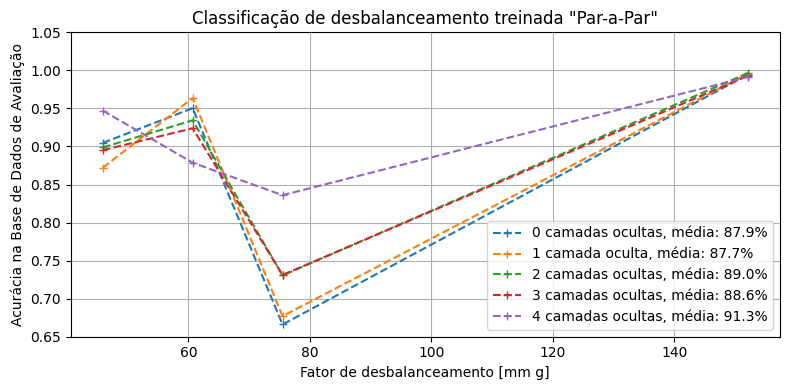

In [ ]:
fig=plt.figure(figsize=(8,4))
ax1=plt.subplot(111, title = 'Classificação de desbalanceamento treinada "Par-a-Par"')
unbalances = np.array([0, 4.59e-5, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances[1:], accuracies[0,:], label=f"0 camadas ocultas, média: {accuracies_mean[0]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies[1,:], label=f"1 camada oculta, média: {accuracies_mean[1]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies[2,:], label=f"2 camadas ocultas, média: {accuracies_mean[2]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies[3,:], label=f"3 camadas ocultas, média: {accuracies_mean[3]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances[1:], accuracies[4,:], label=f"4 camadas ocultas, média: {accuracies_mean[4]:.1f}%", marker="+", ls="--")
plt.ylabel("Acurácia na Base de Dados de Avaliação")
plt.xlabel("Fator de desbalanceamento [mm g]")
plt.legend(loc="lower right")
plt.ylim([0.65, 1.05])
plt.grid(True)
plt.tight_layout()
plt.show()